In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
import torch.nn.functional as F

#sns.set()

%matplotlib inline

/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# !pip install xgboost

1. initialize data
- drop MAR,MCAR missing value
- fill MNAR missing value
- type convert(date,price,etc)
- drop outliers
2. feature engineering
- multicollinearity
- one hot encode
3. quick random forest: see the important features
4. tune paremeters

# Initialize Data

## We will clean df2024_2's data the same way as we did to df2024_1, but we will only do analysis on 2024_1. df2024_1's data will be treated as a test_set for neural network training. We could not combine them first and then split the exact test set based on the dates, because the scraped 

In [14]:
df2024_1.columns

Index(['last_scraped', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'inst

In [2]:
df2024_1=pd.read_csv('df2024_1.csv')

In [3]:
df2024_2=pd.read_csv('df2024_2.csv')

In [4]:
df2024_1.drop(['id', 'listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license'],axis=1,inplace=True)

In [5]:
df2024_2.drop(['id', 'listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license'],axis=1,inplace=True)

In [6]:
df2024_1.dtypes

last_scraped                                     object
host_since                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood_cleansed                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bathrooms_text                                   object
bedrooms                                        float64
beds                                            float64
amenities                                        object
price                                           

In [7]:
df2024_1.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,39202.000000,24335.000000,33011.000000,24222.000000,39202.000000,3.920200e+04,39200.000000,39200.000000,3.920000e+04,3.920000e+04,...,27713.000000,27698.000000,27708.000000,27696.000000,27697.000000,39202.000000,39202.000000,39202.000000,39202.000000,27702.000000
mean,2.848860,1.202979,1.403532,1.681736,29.634432,5.640459e+04,29.583495,37.791480,7.686786e+05,1.700019e+06,...,4.629591,4.814092,4.808529,4.727991,4.624456,46.842661,24.227565,21.772690,0.050508,0.953946
std,2.029674,0.556281,0.953565,1.254421,30.172981,1.084709e+07,32.040758,60.007764,4.057712e+07,6.036737e+07,...,0.553984,0.420550,0.448769,0.418802,0.518733,146.693303,120.567818,86.976619,0.369496,1.633604
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.000000,1.000000,1.000000,1.000000,30.000000,1.500000e+02,30.000000,30.000000,3.650000e+02,3.650000e+02,...,4.500000,4.800000,4.800000,4.630000,4.510000,1.000000,0.000000,0.000000,0.000000,0.100000
50%,2.000000,1.000000,1.000000,1.000000,30.000000,3.650000e+02,30.000000,30.000000,1.125000e+03,1.125000e+03,...,4.800000,4.940000,4.960000,4.840000,4.760000,1.000000,1.000000,1.000000,0.000000,0.360000
75%,4.000000,1.000000,2.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,...,5.000000,5.000000,5.000000,5.000000,4.930000,6.000000,2.000000,2.000000,0.000000,1.300000
max,16.000000,15.500000,26.000000,42.000000,1250.000000,2.147484e+09,1250.000000,1250.000000,2.147484e+09,2.147484e+09,...,5.000000,5.000000,5.000000,5.000000,5.000000,827.000000,827.000000,599.000000,8.000000,78.250000


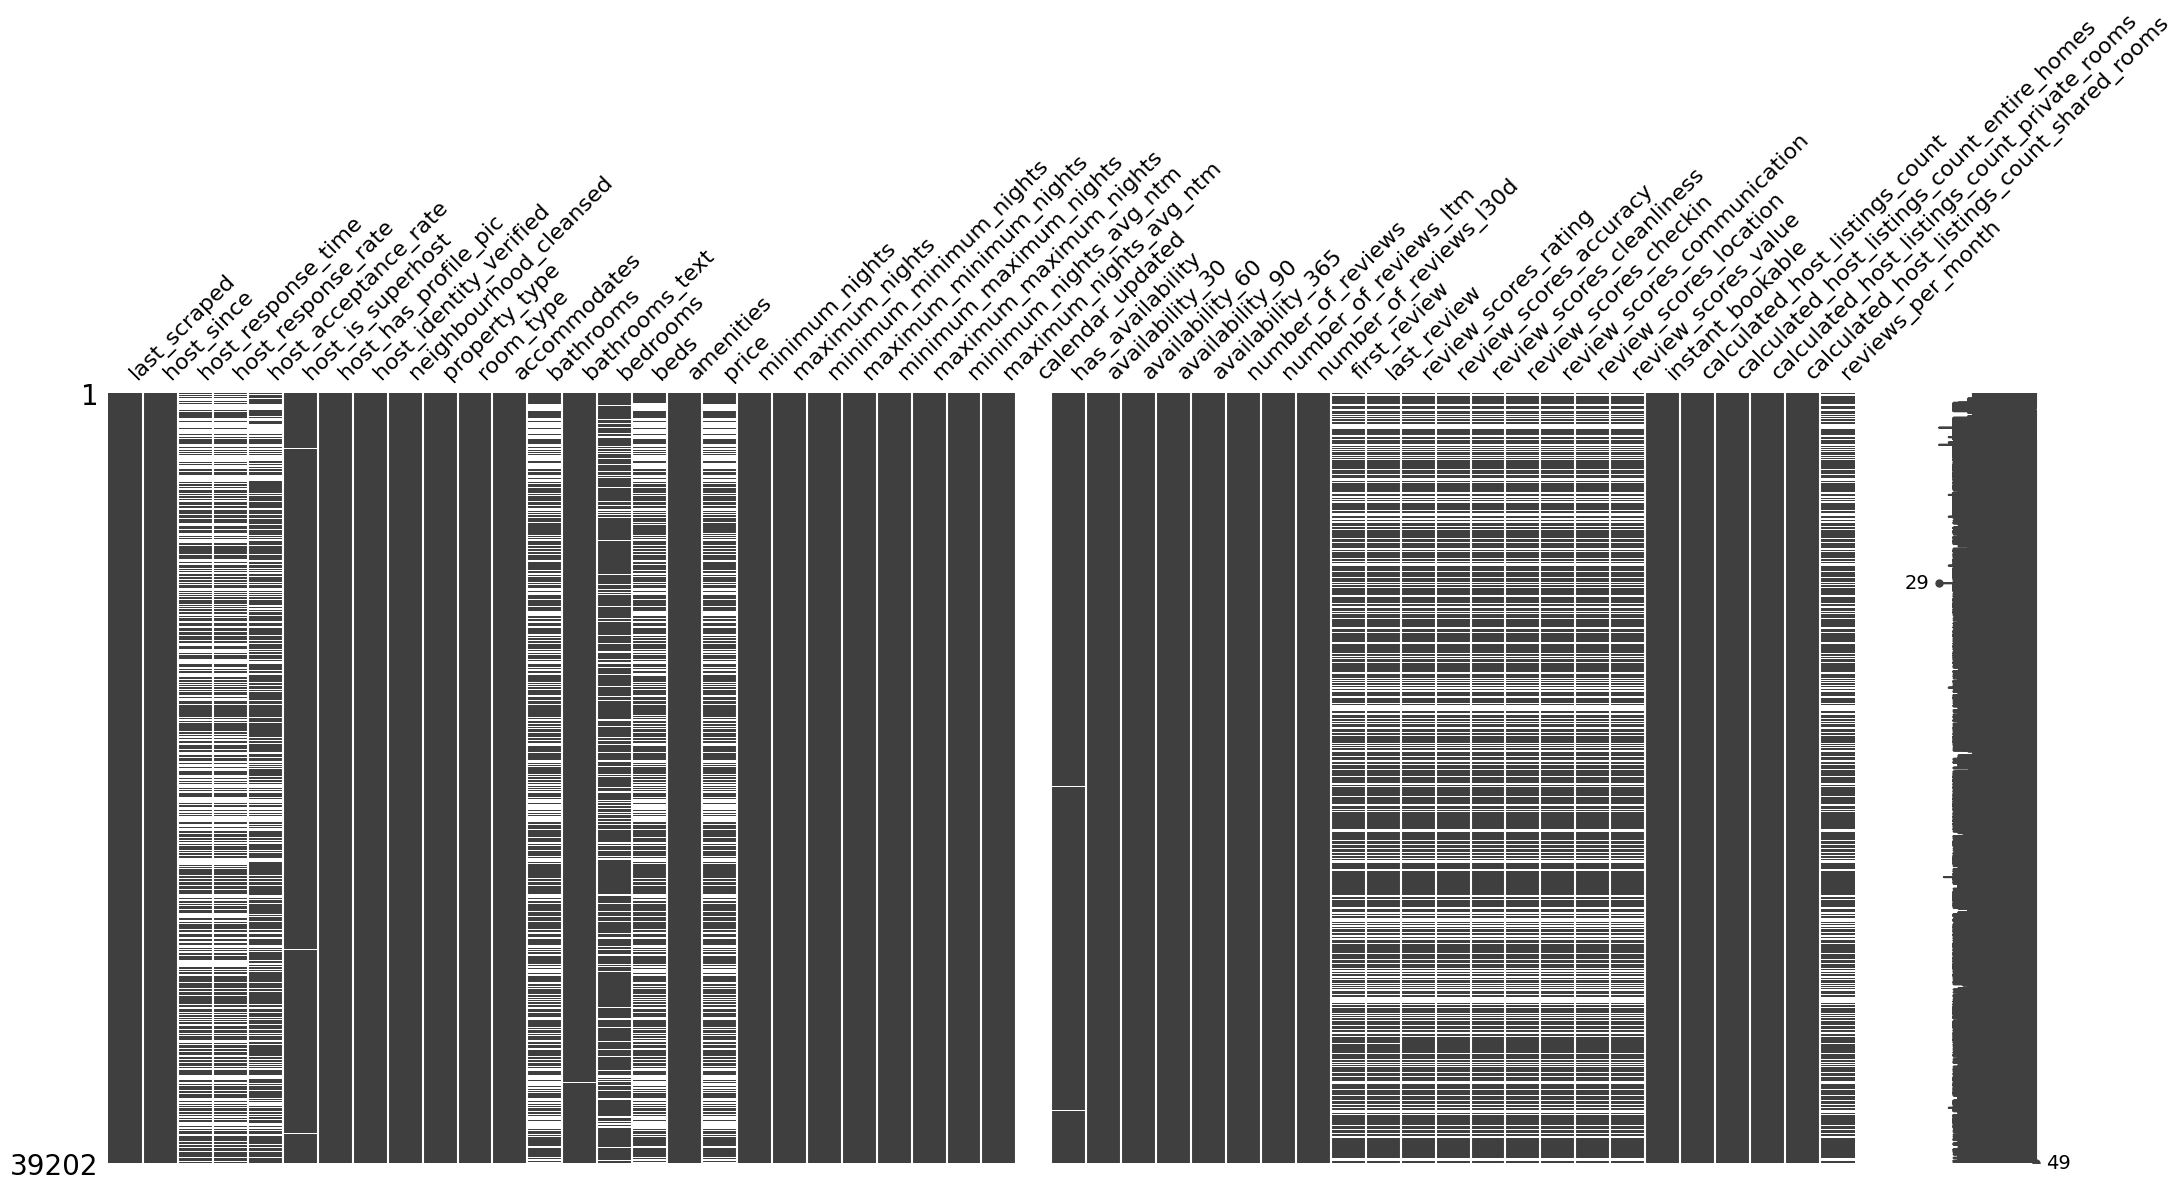

ValueError: could not convert string to float: '--'

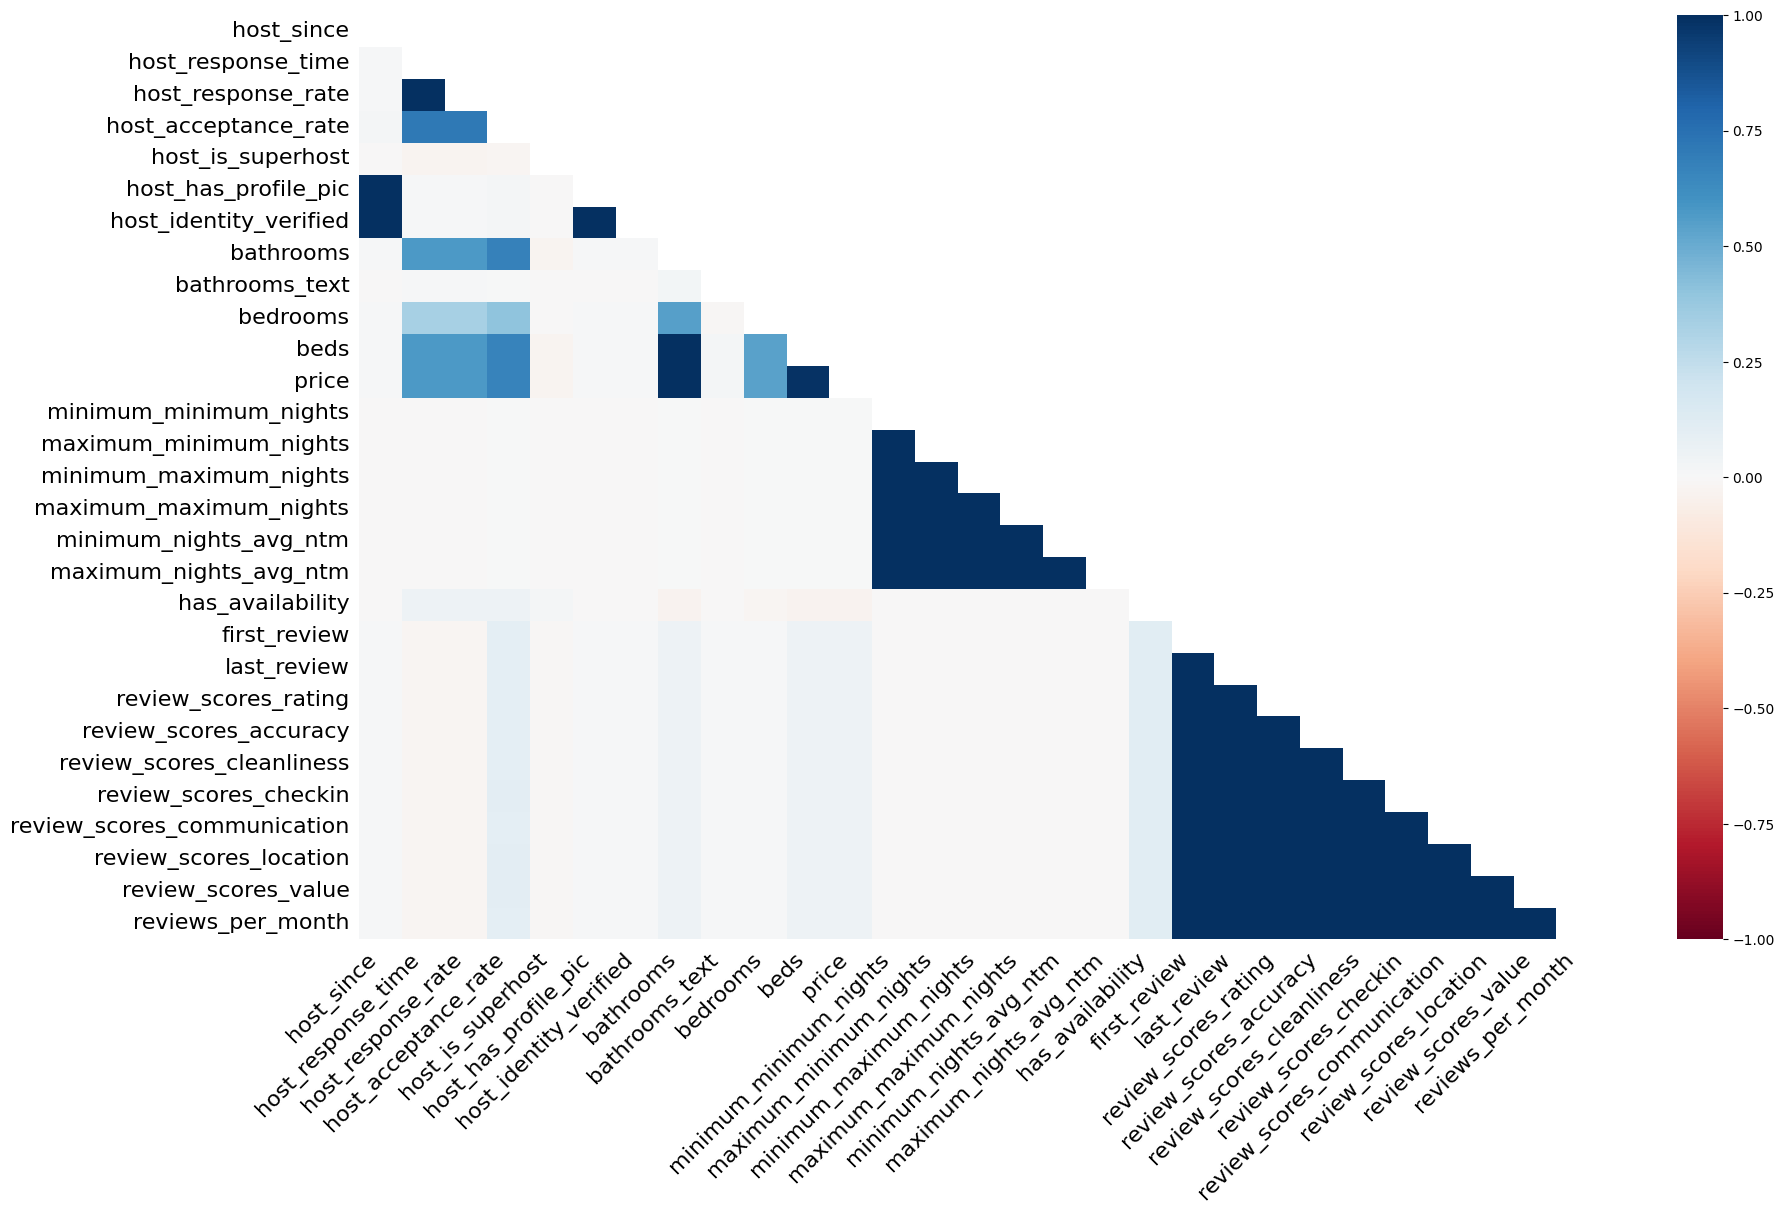

In [8]:
# Visualize the missingness matrix
msno.matrix(df2024_1)
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1)
plt.show()

In [9]:
# drop missing values
columns_to_check = ['host_since', 'host_is_superhost', 'has_availability', 'calendar_updated', 'bathrooms_text','price']
threshold = 0.7  # 70% threshold for missing values

for col in columns_to_check:
    missing_proportion = df2024_1[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        df2024_1.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        df2024_1 = df2024_1.dropna(subset=[col])

In [10]:
df2024_1.head()

,last_scraped,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2024-02-06,2016-09-15,a few days or more,0%,54%,f,t,t,Sheepshead Bay,Private room in home,...,4.00,4.00,4.00,3.00,f,7,1,6,0,0.86
1,2024-02-06,2021-09-04,within an hour,100%,97%,t,t,t,Kingsbridge,Private room in rental unit,...,4.94,4.83,4.94,4.94,f,3,0,3,0,0.95
2,2024-02-06,2022-10-21,within an hour,100%,100%,t,t,t,Howard Beach,Private room in rental unit,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN
3,2024-02-06,2016-08-04,within a day,50%,86%,t,t,t,Bedford-Stuyvesant,Private room in home,...,4.93,4.94,4.86,4.75,f,3,0,3,0,2.14
4,2024-02-10,2012-08-11,within an hour,99%,18%,t,t,t,Flatbush,Private room in rental unit,...,NaN,NaN,NaN,NaN,f,600,1,599,0,NaN


In [10]:
# drop missing values
columns_to_check = ['host_since', 'host_is_superhost', 'has_availability', 'calendar_updated', 'bathrooms_text','price']
threshold = 0.7  # 70% threshold for missing values

for col in columns_to_check:
    missing_proportion = df2024_2[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        df2024_2.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        df2024_2 = df2024_2.dropna(subset=[col])

In [11]:
# 确定price还在
df2024_1.price.describe()

count       23914
unique        913
top       $100.00
freq          645
Name: price, dtype: object

In [12]:
# 确定price还在
df2024_2.price.describe()

count       17657
unique        826
top       $100.00
freq          434
Name: price, dtype: object

In [13]:
# fill missing values
# numeric columns
numeric_cols = df2024_1.select_dtypes(include=['number']).columns

# Then identify those numeric columns that have missing values
numeric_cols_with_missing = numeric_cols[df2024_1[numeric_cols].isna().any(axis=0)]

# Now iterate over those columns and print min/max if the minimum is not zero, then fill NaN with 0
for col in numeric_cols_with_missing:
    if df2024_1[col].min(skipna=True) != 0:
        print(f"{col} - Min: {df2024_1[col].min()}, Max: {df2024_1[col].max()}")
        df2024_1[col].fillna(0, inplace=True)

minimum_minimum_nights - Min: 1.0, Max: 500.0
maximum_minimum_nights - Min: 1.0, Max: 1000.0
minimum_maximum_nights - Min: 1.0, Max: 2147483647.0
maximum_maximum_nights - Min: 2.0, Max: 2147483647.0
minimum_nights_avg_ntm - Min: 1.0, Max: 956.8
maximum_nights_avg_ntm - Min: 2.0, Max: 2147483647.0
review_scores_rating - Min: 1.0, Max: 5.0
review_scores_accuracy - Min: 1.0, Max: 5.0
review_scores_cleanliness - Min: 1.0, Max: 5.0
review_scores_checkin - Min: 1.0, Max: 5.0
review_scores_communication - Min: 1.0, Max: 5.0
review_scores_location - Min: 1.0, Max: 5.0
review_scores_value - Min: 1.0, Max: 5.0
reviews_per_month - Min: 0.01, Max: 78.25


In [13]:
df2024_2.head()

,last_scraped,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2024-03-08,2015-10-21,NaN,NaN,52%,f,t,t,Long Island City,Tiny home,...,5.0,5.0,5.0,5.0,f,2,2,0,0,0.96
1,2024-03-08,2015-10-02,NaN,NaN,NaN,f,t,t,Inwood,Entire rental unit,...,4.2,4.2,3.8,4.0,f,1,1,0,0,0.05
2,2024-03-08,2013-08-05,NaN,NaN,NaN,f,t,t,Boerum Hill,Private room in townhouse,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,2024-03-08,2012-08-31,NaN,NaN,NaN,f,t,t,DUMBO,Private room in rental unit,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
4,2024-03-08,2018-10-16,NaN,NaN,NaN,f,t,t,Long Island City,Private room in rental unit,...,3.0,2.0,4.0,2.0,f,1,0,1,0,0.02


In [14]:
# fill missing values
# numeric columns
numeric_cols = df2024_2.select_dtypes(include=['number']).columns

# Then identify those numeric columns that have missing values
numeric_cols_with_missing = numeric_cols[df2024_2[numeric_cols].isna().any(axis=0)]

# Now iterate over those columns and print min/max if the minimum is not zero, then fill NaN with 0
for col in numeric_cols_with_missing:
    if df2024_2[col].min(skipna=True) != 0:
        print(f"{col} - Min: {df2024_2[col].min()}, Max: {df2024_2[col].max()}")
        df2024_2[col].fillna(0, inplace=True)

review_scores_rating - Min: 1.0, Max: 5.0
review_scores_accuracy - Min: 1.0, Max: 5.0
review_scores_cleanliness - Min: 1.0, Max: 5.0
review_scores_checkin - Min: 1.0, Max: 5.0
review_scores_communication - Min: 1.0, Max: 5.0
review_scores_location - Min: 1.0, Max: 5.0
review_scores_value - Min: 1.0, Max: 5.0
reviews_per_month - Min: 0.01, Max: 86.03


In [15]:
# fill missing values
# review columns

# 将字符串转换为Datetime
df2024_1['last_scraped'] = pd.to_datetime(df2024_1['last_scraped'])
for col in ['host_since', 'first_review', 'last_review']:
    # Ensure that the column is in datetime format
    df2024_1[col] = pd.to_datetime(df2024_1[col], errors='coerce')  # Use 'coerce' to handle any parsing errors

# # 添加缺失值标记列
# for col in ['first_review', 'last_review', 'review_scores_rating',
#             'review_scores_accuracy', 'review_scores_cleanliness',
#             'review_scores_checkin', 'review_scores_communication',
#             'review_scores_location', 'review_scores_value']:

#     missing_col_name = col + '_missing'  # 新的缺失值标记列名
#     df2024_1[missing_col_name] = df2024_1[col].isna().astype(int)  # 如果缺失则标记为1

# 对于日期列，选择一个填充值，并转换为天数
date_fill_value = df2024_1['first_review'].min(skipna=True)
df2024_1['first_review'].fillna(date_fill_value, inplace=True)
df2024_1['last_review'].fillna(date_fill_value, inplace=True)

# 转换日期列为天数
df2024_1['days_since_first_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['first_review'])).dt.days
df2024_1['days_since_last_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['last_review'])).dt.days
df2024_1['days_since_host_since'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['host_since'])).dt.days
df2024_1['days_since_first_review'] = df2024_1['days_since_first_review'].astype(float)
df2024_1['days_since_last_review'] = df2024_1['days_since_last_review'].astype(float)
df2024_1['days_since_host_since'] = df2024_1['days_since_host_since'].astype(float)

# 对于评分类列，使用中性值填充缺失值
for score_col in ['review_scores_rating', 'review_scores_accuracy',
                  'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location',
                  'review_scores_value']:
    neutral_value = 2.5
    df2024_1[score_col].fillna(neutral_value, inplace=True)

df2024_1.drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)
# host_since缺失值已经在前面被删掉

In [27]:
# fill missing values
# review columns

# 将字符串转换为Datetime
df2024_2['last_scraped'] = pd.to_datetime(df2024_2['last_scraped'])
for col in ['host_since', 'first_review', 'last_review']:
    # Ensure that the column is in datetime format
    df2024_2[col] = pd.to_datetime(df2024_2[col], errors='coerce')  # Use 'coerce' to handle any parsing errors

# # 添加缺失值标记列
# for col in ['first_review', 'last_review', 'review_scores_rating',
#             'review_scores_accuracy', 'review_scores_cleanliness',
#             'review_scores_checkin', 'review_scores_communication',
#             'review_scores_location', 'review_scores_value']:

#     missing_col_name = col + '_missing'  # 新的缺失值标记列名
#     df2024_2[missing_col_name] = df2024_2[col].isna().astype(int)  # 如果缺失则标记为1

# 对于日期列，选择一个填充值，并转换为天数
date_fill_value = df2024_2['first_review'].min(skipna=True)
df2024_2['first_review'].fillna(date_fill_value, inplace=True)
df2024_2['last_review'].fillna(date_fill_value, inplace=True)

# 转换日期列为天数
df2024_2['days_since_first_review'] = (df2024_2['last_scraped'] - pd.to_datetime(df2024_2['first_review'])).dt.days
df2024_2['days_since_last_review'] = (df2024_2['last_scraped'] - pd.to_datetime(df2024_2['last_review'])).dt.days
df2024_2['days_since_host_since'] = (df2024_2['last_scraped'] - pd.to_datetime(df2024_2['host_since'])).dt.days
df2024_2['days_since_first_review'] = df2024_2['days_since_first_review'].astype(float)
df2024_2['days_since_last_review'] = df2024_2['days_since_last_review'].astype(float)
df2024_2['days_since_host_since'] = df2024_2['days_since_host_since'].astype(float)

# 对于评分类列，使用中性值填充缺失值
for score_col in ['review_scores_rating', 'review_scores_accuracy',
                  'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location',
                  'review_scores_value']:
    neutral_value = 2.5
    df2024_2[score_col].fillna(neutral_value, inplace=True)

df2024_2.drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)
# host_since缺失值已经在前面被删掉

In [16]:
# string to float
df2024_1['host_acceptance_rate'] = df2024_1['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df2024_1['host_response_rate'] = df2024_1['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [17]:
# string to float
df2024_2['host_acceptance_rate'] = df2024_2['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df2024_2['host_response_rate'] = df2024_2['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [18]:
columns_to_convert = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]

# Assuming that 't' represents True and 'f' represents False in your dataset
bool_mapping = {'t': True, 'f': False}

for col in columns_to_convert:
    # Map the 't'/'f' values to True/False
    df2024_1[col] = df2024_1[col].map(bool_mapping)

In [19]:
columns_to_convert = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]

# Assuming that 't' represents True and 'f' represents False in your dataset
bool_mapping = {'t': True, 'f': False}

for col in columns_to_convert:
    # Map the 't'/'f' values to True/False
    df2024_2[col] = df2024_2[col].map(bool_mapping)

In [20]:
# Remove both the dollar sign and commas, then convert to float
df2024_1['price'] = df2024_1['price'].replace('[\$,]', '', regex=True).astype(float)

In [21]:
# Remove both the dollar sign and commas, then convert to float
df2024_2['price'] = df2024_2['price'].replace('[\$,]', '', regex=True).astype(float)

In [22]:
missing_values_count = df2024_1.isna().sum()

# Filter and print only those columns that have non-zero missing values
non_zero_missing = missing_values_count[missing_values_count != 0]
print(non_zero_missing)

host_response_time      5466
host_response_rate      5466
host_acceptance_rate    1724
bedrooms                  46
beds                     114
dtype: int64


In [23]:
missing_values_count = df2024_2.isna().sum()

# Filter and print only those columns that have non-zero missing values
non_zero_missing = missing_values_count[missing_values_count != 0]
print(non_zero_missing)

host_response_time      3745
host_response_rate      3745
host_acceptance_rate    1238
bedrooms                  34
beds                     130
first_review            4792
last_review             4792
dtype: int64


In [24]:
df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']].describe()

,host_response_rate,host_acceptance_rate,bedrooms,beds
count,18448.000000,22190.000000,23868.000000,23800.000000
mean,0.940187,0.808767,1.374141,1.685210
std,0.176757,0.268407,0.966722,1.256933
min,0.000000,0.000000,0.000000,0.000000
25%,0.990000,0.730000,1.000000,1.000000
50%,1.000000,0.940000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000
max,1.000000,1.000000,16.000000,42.000000


In [25]:
df2024_2[['host_response_rate','host_acceptance_rate','bedrooms','beds']].describe()

,host_response_rate,host_acceptance_rate,bedrooms,beds
count,13912.000000,16419.000000,17623.000000,17527.000000
mean,0.941489,0.821337,1.353459,1.649855
std,0.180407,0.267218,0.957421,1.272524
min,0.000000,0.000000,0.000000,0.000000
25%,0.990000,0.750000,1.000000,1.000000
50%,1.000000,0.950000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000
max,1.000000,1.000000,16.000000,42.000000


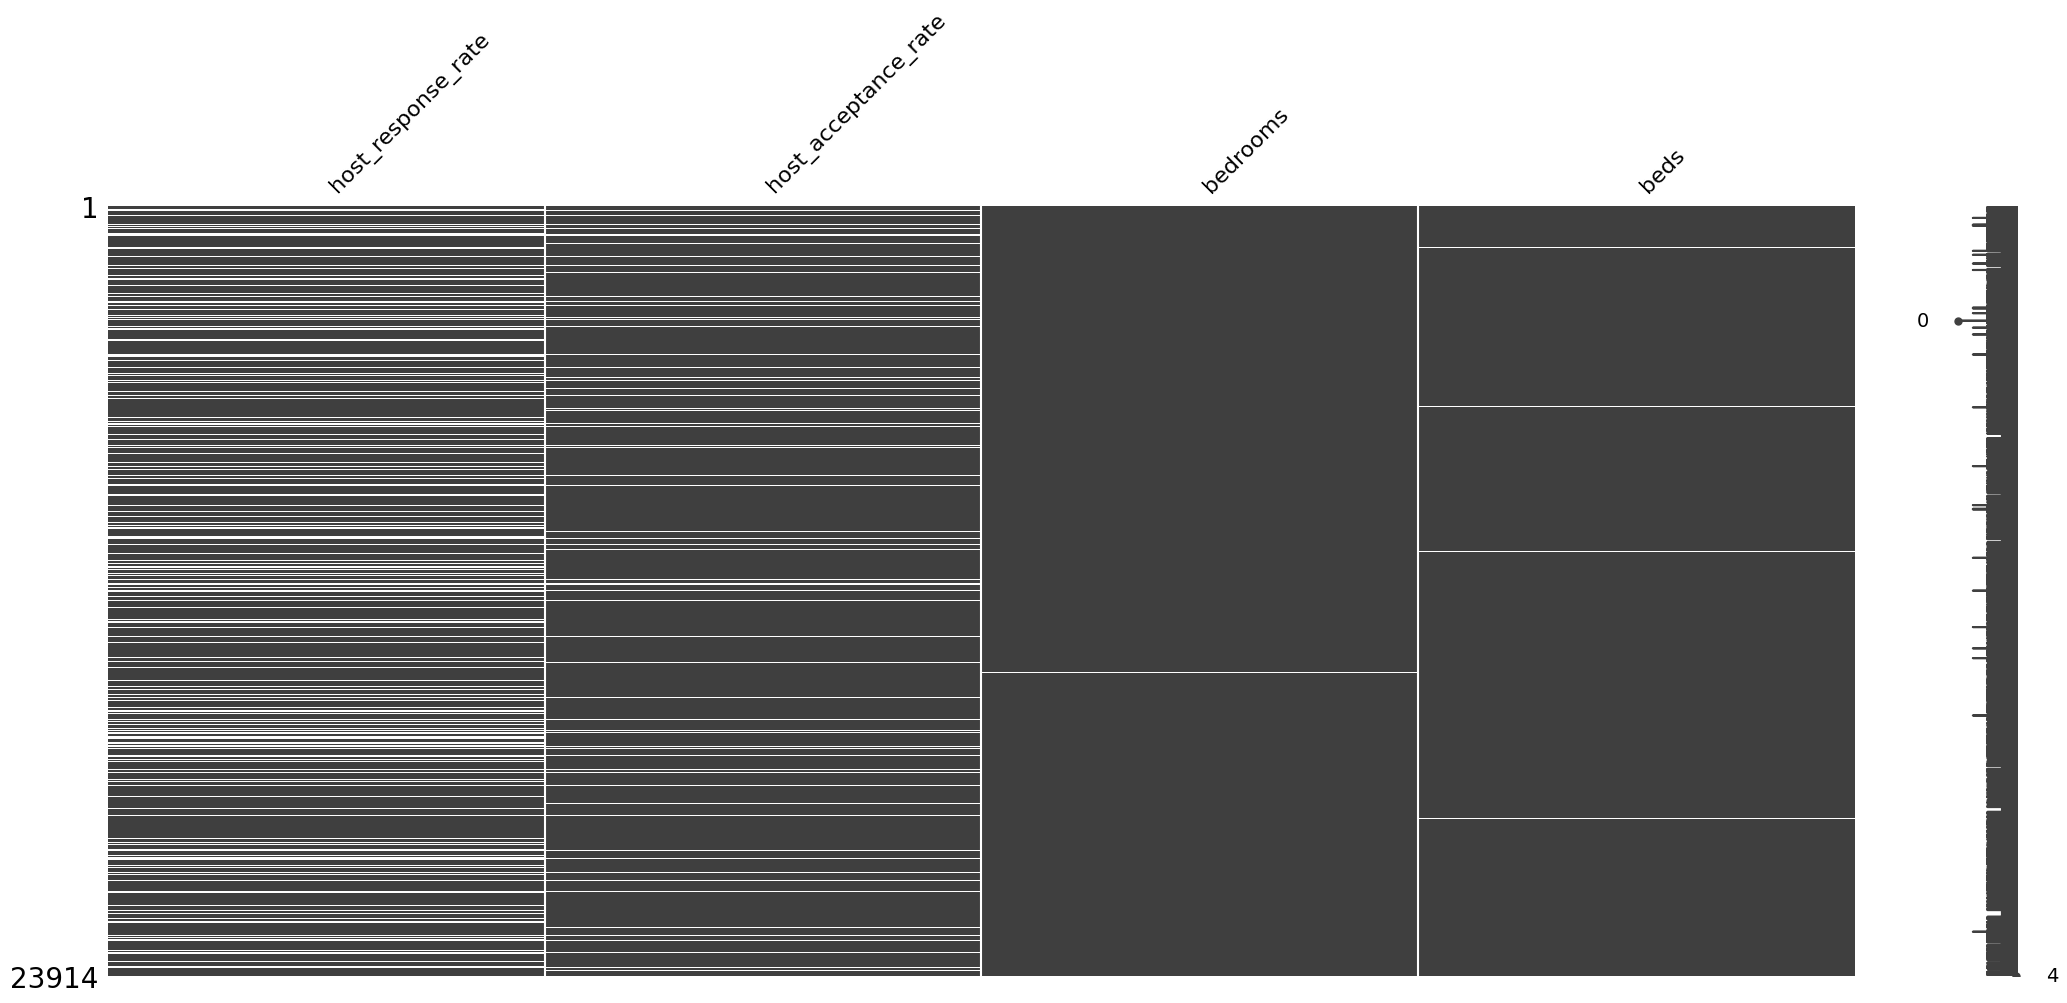

ValueError: could not convert string to float: '--'

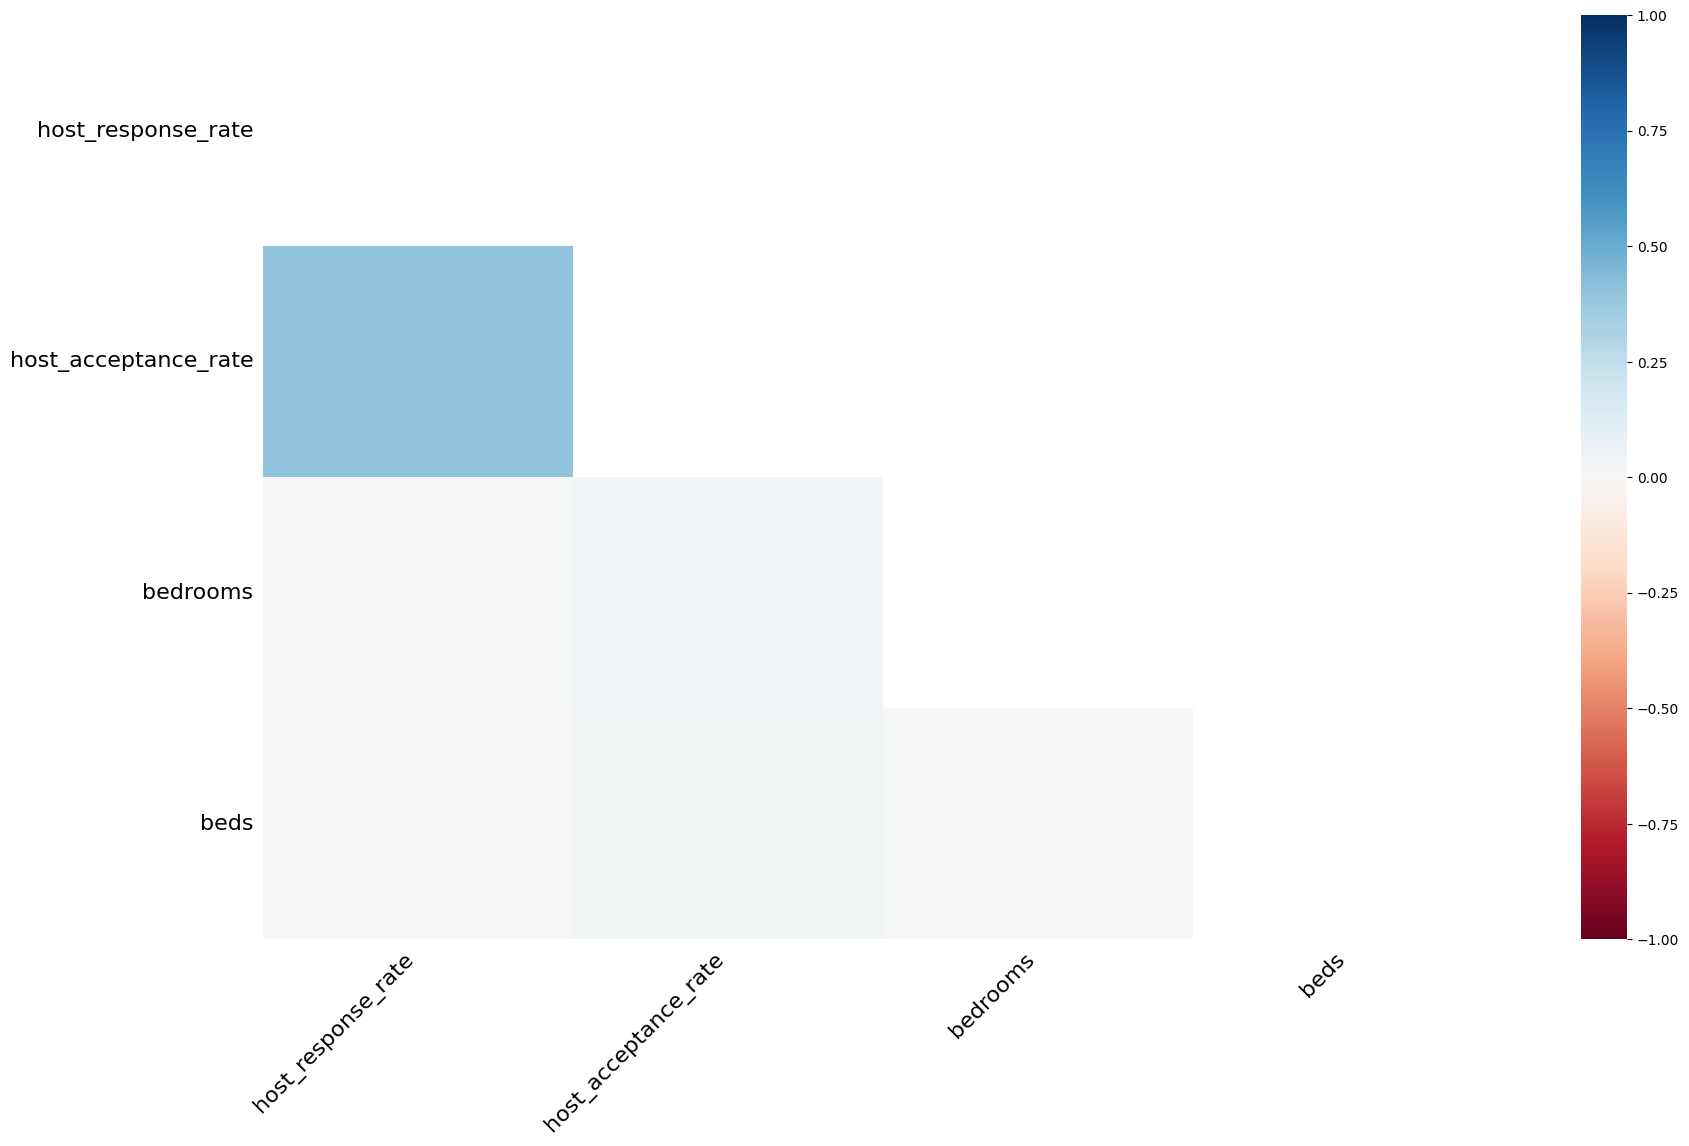

In [26]:
# Visualize the missingness matrix
msno.matrix(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

In [27]:
# 删除包含任何缺失值的行
df2024_1 = df2024_1.dropna(subset=['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds'])

In [28]:
# 删除包含任何缺失值的行
df2024_2 = df2024_2.dropna(subset=['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds'])

In [37]:
len(df2024_1.columns)

35

In [38]:
df2024_2.columns

Index(['last_scraped', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_s

# Feature Engineering

## multicollinearity

In [31]:
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
df2024_1['review_score_mean'] = df2024_1[review_score_columns].mean(axis=1)
df2024_1.drop(review_score_columns,axis=1,inplace=True)

In [32]:
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
df2024_2['review_score_mean'] = df2024_2[review_score_columns].mean(axis=1)
df2024_2.drop(review_score_columns,axis=1,inplace=True)

In [33]:
multicollinearity_drop_columns=[
    'maximum_nights_avg_ntm','availability_60','availability_90','calculated_host_listings_count','minimum_nights_avg_ntm','days_since_first_review','minimum_minimum_nights'
]
df2024_1.drop(multicollinearity_drop_columns,axis=1,inplace=True)

In [34]:
multicollinearity_drop_columns=[
    'maximum_nights_avg_ntm','availability_60','availability_90','calculated_host_listings_count','minimum_nights_avg_ntm','days_since_first_review','minimum_minimum_nights'
]
df2024_2.drop(multicollinearity_drop_columns,axis=1,inplace=True)

KeyError: "['days_since_first_review'] not found in axis"

In [49]:
# drop outliers
numeric_cols = df2024_1.select_dtypes(include=['number'])
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(numeric_cols)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
numeric_cols = numeric_cols.drop(numeric_cols.index[outlier_indices])

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [22]:
# drop outliers
numeric_cols = df2024_1.select_dtypes(include=['number'])
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(numeric_cols)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
numeric_cols = numeric_cols.drop(numeric_cols.index[outlier_indices])

In [23]:
numeric_cols=numeric_cols[numeric_cols.price<100000]

In [24]:
numeric_cols.shape

(16406, 24)

In [25]:
# numeric_cols = df2024_1.select_dtypes(include=['number'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# 计算VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_cols.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

In [26]:
# 严重多重共线性
has_multiL_problem=vif_data[vif_data['VIF']>=10]
display(has_multiL_problem)

,feature,VIF
0,host_response_rate,37.204860
1,host_acceptance_rate,19.016753
21,days_since_last_review,11.746381
23,review_score_mean,33.729203


## Encode Labels

In [27]:
# 将amenities的每个列表长度计算出来，作为新的特征
df2024_1['amenities_count'] = df2024_1['amenities'].apply(lambda x: len(eval(x)))

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

# 首先，确保amenities里的每个项都是列表
df2024_1['amenities'] = df2024_1['amenities'].apply(eval)

# 使用MultiLabelBinarizer进行one-hot编码
mlb = MultiLabelBinarizer()
amenities_encoded = mlb.fit_transform(df2024_1['amenities'])
amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_, index=df2024_1.index)

# 将新的DataFrame合并回原始DataFrame
df = pd.concat([df2024_1, amenities_df], axis=1)

# 删除原始的amenities列
df2024_1.drop('amenities', axis=1, inplace=True)

In [29]:
label_selected_cols = [
  'host_response_time',
  'bathrooms_text'
 ]
for col in df2024_1.columns:
    if col in label_selected_cols:
        label_encoder = LabelEncoder()
        df2024_1[col]=df2024_1[col].fillna('Missing')
        df2024_1[col + '_LabelEncoded'] = label_encoder.fit_transform(df2024_1[col])
        df2024_1 = df2024_1.drop(columns=[col])

In [30]:
label_selected_cols = [
  'neighbourhood_cleansed',
  'property_type',
  'room_type'
 ]
# 1. 计算中位数和平均房价的阈值
quantiles = df2024_1['price'].quantile([0.25, 0.75])
mean_price = df2024_1['price'].mean()
median_price = df2024_1['price'].median()

# 2. 创建布尔列
df2024_1['expensive_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() < quantiles[0.25])

# 3. 独热编码
df2024_1 = pd.get_dummies(df2024_1, columns=label_selected_cols)

# 4. 删除True个数小于5的列
for col in df2024_1.columns:
    if df2024_1[col].dtype == 'uint8' and df2024_1[col].sum() < 10:
        df2024_1.drop(col, axis=1, inplace=True)

## Outlies

In [31]:
# drop outliers
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(df2024_1)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
df2024_1 = df2024_1.drop(df2024_1.index[outlier_indices])

In [32]:
df2024_1=df2024_1[df2024_1.price<100000]

In [33]:
df2024_1.shape

(18042, 314)

# Models

- 未进行特征选择的模型测试：(模型：xg_reg，rf)
- 使用随机森林进行特征选择后的模型(模型：best_rf_XGB,best_rf_rf)
- 使用XGBoost进行特征选择后的模型(模型：best_xgb_XGB,best_xgb_rf)
- PCA降维后的模型(模型：best_pca_XGB,best_pca_rf)



## Standardization

In [34]:
# X = df2024_1.drop(['price'],axis=1)
features = df2024_1.drop(['price'], axis=1)  # 选择特征列
scaler = preprocessing.StandardScaler().fit(features)  # 拟合scaler

# 使用拟合的scaler来变换数据
X_scaled = scaler.transform(features)

# 创建一个新的DataFrame，用变换后的数据和原来的列名
X = pd.DataFrame(X_scaled, columns=features.columns)
y = np.log(df2024_1[['price']])
# y = df2024_1[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [35]:
from sklearn.metrics import mean_absolute_percentage_error

def scores(X_train, X_test, y_train, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # 计算R2
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    # 计算训练集上的MSE和RMSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    # 计算测试集上的MSE和RMSE
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    # 计算训练集和测试集上的MAPE
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train R2 score: {train_score}, Test R2 score {test_score}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train MAPE: {train_mape}, Test MAPE: {test_mape}")

# 用你的模型实例替换'model'
# scores(X_train, X_test, y_train, y_test, model)


In [36]:
def n_r2score_plot(estimators,mod,X_train, X_test, y_train, y_test):
#     estimators: a list of number
#     mod: 0-XGBoost, 1 - random forest

    train_scores = []
    test_scores = []
    for n in estimators:
        if mod==1:
            model = RandomForestRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        else:
            model = xgb.XGBRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_scores.append(r2_score(y_train, train_pred))
        test_scores.append(r2_score(y_test, test_pred))

    # 绘制线图
    plt.figure(figsize=(10, 6))
    plt.plot(estimators, train_scores, label='Training R2 Score')
    plt.plot(estimators, test_scores, label='Testing R2 Score')
    plt.xlabel('Number of Estimators')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs. Number of Estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

In [37]:
def grid_tune(param_grid, mod, ver, X_train, y_train):
    # 选择模型
    if mod == 0:
        model = xgb.XGBRegressor(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)

    # 初始化网格搜索对象
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='r2', cv=5, verbose=ver, n_jobs=-1)

    # 执行网格搜索
    grid_search.fit(X_train, y_train)  # 使用正确的变量

    # 打印最优参数和对应的评估分数
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R2 Score: ", grid_search.best_score_)

    return grid_search.best_estimator_

In [38]:
def feature_importance_ranking(model, columns):
    feature_importances = model.feature_importances_

    # 将特征重要性转换为DataFrame以方便绘图
    features_df = pd.DataFrame({'Features': columns, 'Importance Score': feature_importances})
    features_df = features_df.sort_values(by='Importance Score', ascending=False)

    # 绘制特征重要性条形图
    plt.figure(figsize=(50,50))
    sns.barplot(x='Importance Score', y='Features', data=features_df)
    plt.title(f'Feature Importances')
    plt.show()

## test on XGBoost

In [39]:
# 初始化XGBoost回归模型
xg_reg = xgb.XGBRegressor(random_state=42)
xg_reg.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,xg_reg)

Train R2 score: 0.8943535034074747, Test R2 score 0.7929831949642622
Train MSE: 0.06571374046171408, Test MSE: 0.13394795715118368
Train RMSE: 0.2563469142816314, Test RMSE: 0.36598901233668707
Train MAPE: 0.038615142049466006, Test MAPE: 0.053896513606461145


## test on random forest

In [40]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,rf)

Train R2 score: 0.969425091323932, Test R2 score 0.7897904263349127
Train MSE: 0.01901806191575975, Test MSE: 0.13601380313641145
Train RMSE: 0.137905989412207, Test RMSE: 0.36880049232127043
Train MAPE: 0.018996956249885552, Test MAPE: 0.05271819157880829


When the $R^2$ score on the training data is significantly higher than the $R^2$ score on the test data, it indicates that the model is overfitting.

## feature selection-RF

In [41]:
# 打印特征重要性
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 选择重要性得分高于平均水平的特征
sfm = SelectFromModel(rf, threshold='median', prefit=True)
X_train_rf_selected = sfm.transform(X_train)
X_test_rf_selected = sfm.transform(X_test)

In [42]:
# 获取选中的特征的布尔掩码
selected_mask = sfm.get_support()

# 打印被选中的特征名称
selected_features = X_train.columns[selected_mask]
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       ...
       'property_type_Room in aparthotel',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'property_type_Shared room in home',
       'property_type_Shared room in loft',
       'property_type_Shared room in rental unit', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object', length=157)


### baseline model-XGBoost

In [43]:
# 初始化XGBoost回归模型
xg_reg_rf_features = xgb.XGBRegressor(random_state=42)
xg_reg_rf_features.fit(X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,xg_reg_rf_features)

Train R2 score: 0.9091036780801113, Test R2 score 0.7969816792510047
Train MSE: 0.05653890569231228, Test MSE: 0.13136078167130993
Train RMSE: 0.2377791111353398, Test RMSE: 0.3624372796378843
Train MAPE: 0.03616707115940416, Test MAPE: 0.05288257501953279


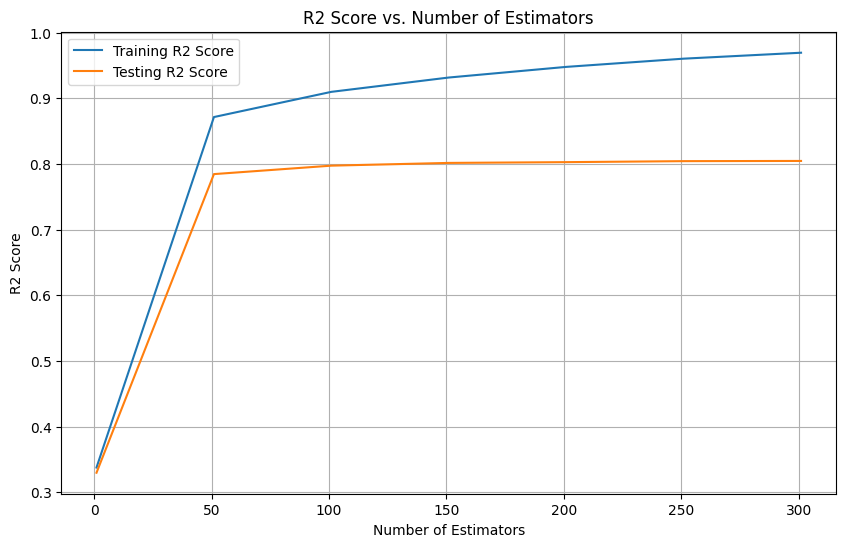

In [44]:
n_r2score_plot(range(1,302,50),0,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [45]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [100,200,250],
    'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_rf_XGB = grid_tune(param_grid, 0, 2, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_XGB)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWar

Best parameters found:  {'min_child_weight': 2, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.01}
Best R2 Score:  0.8030027193324024
Train R2 score: 0.9591806412457266, Test R2 score 0.8019581371480191
Train MSE: 0.025390266913798493, Test MSE: 0.12814081907436578
Train RMSE: 0.1593432361721027, Test RMSE: 0.35796762294146905
Train MAPE: 0.02395552020764349, Test MAPE: 0.05183492611032383


### baseline model-RF

In [46]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_rf_selected, y_train)

scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9695392820494647, Test R2 score 0.7888881357862115
Train MSE: 0.018947033533912493, Test MSE: 0.13659762035711714
Train RMSE: 0.13764822386762748, Test RMSE: 0.3695911529746311
Train MAPE: 0.018947104027511603, Test MAPE: 0.05282277973237559


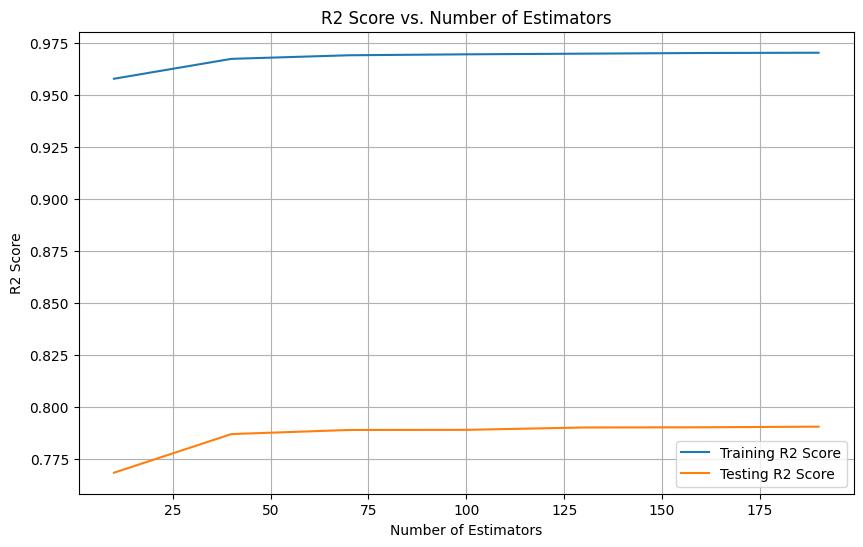

In [47]:
n_r2score_plot(range(10,201,30),1,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [ ]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [110,180,250],
#     'max_depth': [10, 20]
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 2, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_rf)

## feature selection-XGBoost

In [48]:
# 使用内置的特征重要性
selection = SelectFromModel(xg_reg, prefit=True, threshold='median')  # threshold可以是具体的数值或者字符串，如'median'
X_train_XGB_selected = selection.transform(X_train)
X_test_XGB_selected = selection.transform(X_test)


# 查看被选中的特征数量
selected_features_count = X_train_XGB_selected.shape[1]
# 获取被选中的特征名
selected_features = X_train.columns[(selection.get_support())]

# 打印被选中的特征名
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       ...
       'property_type_Private room in loft',
       'property_type_Private room in rental unit',
       'property_type_Private room in townhouse',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'property_type_Shared room in home',
       'property_type_Shared room in rental unit', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=157)


### baseline model-XGBoost

In [49]:
# 初始化XGBoost回归模型
xg_reg_xg_features = xgb.XGBRegressor(random_state=42)
xg_reg_xg_features.fit(X_train_XGB_selected, y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,xg_reg_xg_features)

Train R2 score: 0.90272174093999, Test R2 score 0.794832048584202
Train MSE: 0.060508568429794574, Test MSE: 0.13275167665878718
Train RMSE: 0.2459848947187501, Test RMSE: 0.3643510349357981
Train MAPE: 0.03725715060593171, Test MAPE: 0.053569651123369574


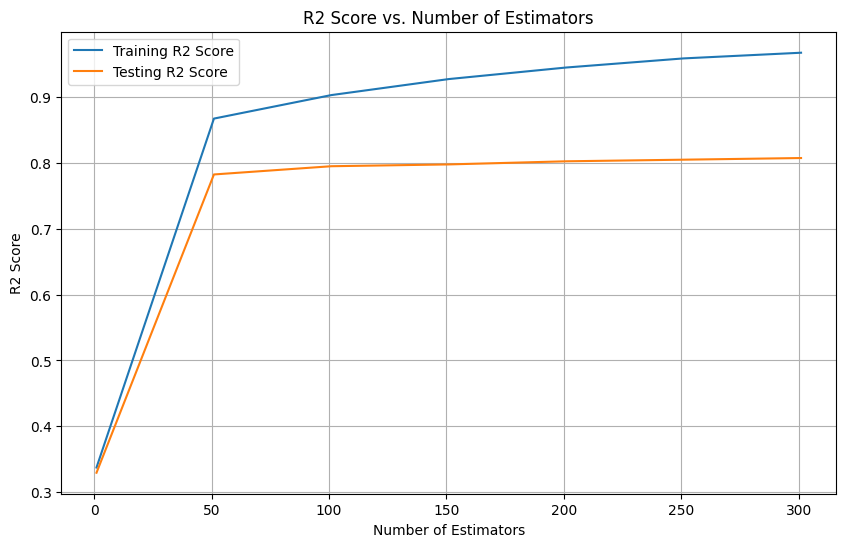

In [50]:
n_r2score_plot(range(1,302,50),0,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [51]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [100,200,250],
    'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_xgb_XGB = grid_tune(param_grid, 0, 2, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected, X_test_XGB_selected,y_train,y_test,best_xgb_XGB)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'min_child_weight': 3, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.1}
Best R2 Score:  0.8037469628358936
Train R2 score: 0.956753991590732, Test R2 score 0.805432659839352
Train MSE: 0.026899680200212217, Test MSE: 0.1258926672081483
Train RMSE: 0.16401121973881, Test RMSE: 0.354813566832144
Train MAPE: 0.024816522201537756, Test MAPE: 0.05130085062511313


### baseline model-RF

In [52]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_XGB_selected, y_train)

scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9694684601553315, Test R2 score 0.7886800211965647
Train MSE: 0.018991085837776686, Test MSE: 0.13673227862378173
Train RMSE: 0.1378081486624673, Test RMSE: 0.3697732800295091
Train MAPE: 0.018996177474035644, Test MAPE: 0.05291806687047632


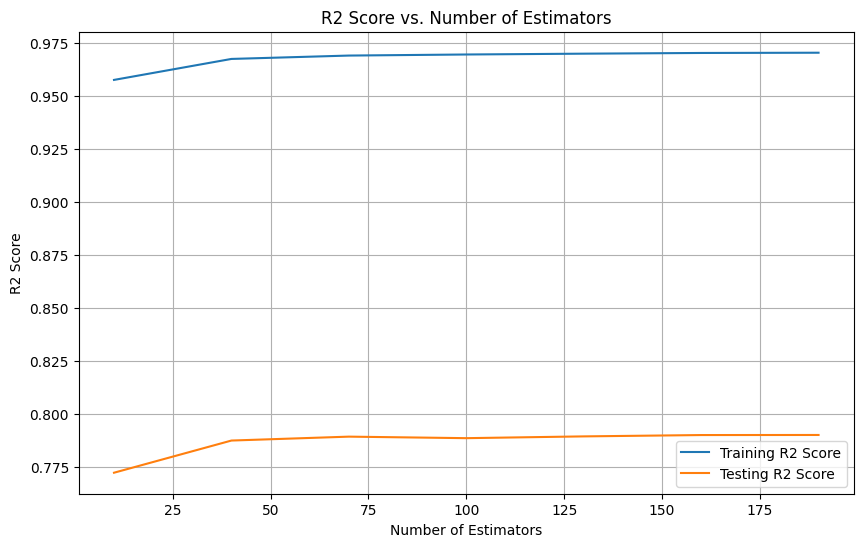

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.01; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   1.6s
[CV] END min_child_weight=

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=1; total time=   1.6s
[CV] END min_child_weight=2,

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.01; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=1; total time=   1.6s
[CV] END min_child_weight=

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.01; total time=   1.8s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   1.7s
[CV] END min_child_weig

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.01; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=1; total time=   1.6s
[CV] END min_child_weight=

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=1; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.001; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.001; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   1.7s
[CV] END min_child_w

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.001; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.01; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=1; total time=   1.7s
[CV] END min_child_weigh

[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.01; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.001, reg_lambda=0.1; total time=   1.2s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.001; total time=   1.4s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1; total time=   1.3s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.01, reg_lambda=1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   1.5s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.001; total time=   1.6s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=0.1; total time=   1.9s
[CV] END min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=1; total time=   1.7s
[CV] END min_child_weight=2

In [53]:
n_r2score_plot(range(10,201,30),1,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [54]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [110,150,200,300],
#     'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 2, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,best_rf_rf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWar

/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

KeyboardInterrupt: 

## feature selection-PCA

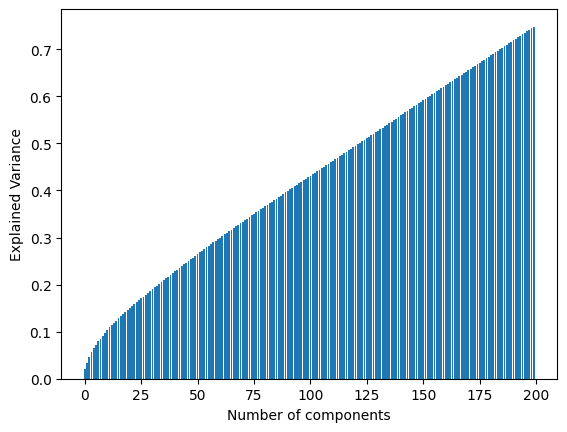

In [55]:
#plot explained variance over the number of compinents
# try to find a best component num
pca = PCA(X.shape[1])
X_S=pca.fit_transform(X)
eigenvalues = pca.explained_variance_ratio_
n= 200
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [56]:
bestPCA = PCA(106)
X_PCA_S_after=bestPCA.fit_transform(X)
X_PCA_S_after.shape

(18042, 106)

In [57]:
components = pd.DataFrame(bestPCA.components_,columns=X.columns)
top_features = components.abs().idxmax(axis=1)

In [58]:
print(top_features)

0                         cheap_room_type
1                       reviews_per_month
2             property_type_Room in hotel
3                                bedrooms
4                   room_type_Shared room
                      ...                
101    neighbourhood_cleansed_Kew Gardens
102         neighbourhood_cleansed_Hollis
103    neighbourhood_cleansed_Columbia St
104        neighbourhood_cleansed_Melrose
105       neighbourhood_cleansed_Van Nest
Length: 106, dtype: object


In [59]:
X_train_PCA_selected, X_test_PCA_selected, y_train, y_test = train_test_split(X_PCA_S_after, y, test_size=0.2, random_state=99)

### baseline model-XGBoost

In [60]:
# 初始化XGBoost回归模型
xg_reg_pca_features = xgb.XGBRegressor(random_state=42)
xg_reg_pca_features.fit(X_train_PCA_selected, y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,xg_reg_pca_features)

Train R2 score: 0.9548107240064018, Test R2 score 0.7530286584735747
Train MSE: 0.02810842242833236, Test MSE: 0.15980010254066604
Train RMSE: 0.16765566625775688, Test RMSE: 0.39975005008213077
Train MAPE: 0.025623582948516205, Test MAPE: 0.05856772918269629


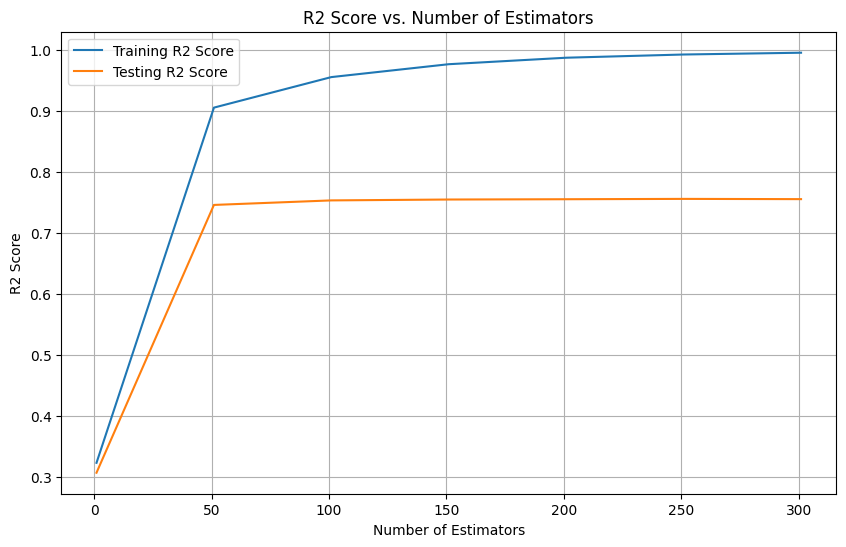

In [61]:
n_r2score_plot(range(1,302,50),0,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

In [ ]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [50,100,200,300],
#     'min_child_weight':range(2,6),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_pca_XGB = grid_tune(param_grid, 0, 2, X_train_PCA_selected,y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,best_pca_XGB)

### baseline model-RF

In [62]:
# baseline model
pca_rf_features = RandomForestRegressor(random_state=42,n_jobs=-1)
pca_rf_features.fit(X_train_PCA_selected, y_train)

scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,pca_rf_features)

Train R2 score: 0.964996840969355, Test R2 score 0.7505985225325451
Train MSE: 0.02177250152223834, Test MSE: 0.16137249539468768
Train RMSE: 0.14755507962194436, Test RMSE: 0.40171195575273544
Train MAPE: 0.02111875455009836, Test MAPE: 0.05838202398158077


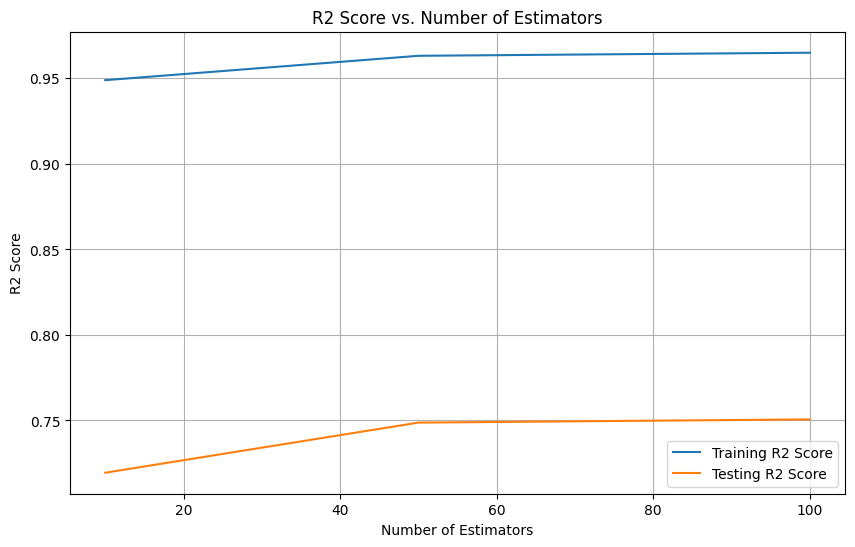

In [63]:
n_r2score_plot([10,50,100],1,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

# Results

<tbody><tr height="29.50" style="height:14.75pt;">
    <td class="xl66" height="63" width="301" rowspan="2" style="height:31.50pt;width:150.50pt;border-right:.5pt solid #000000;border-bottom:1.5pt solid #000000;" x:str="">feature selection method</td>
    <td class="xl67" width="169" rowspan="2" style="width:84.50pt;border-right:.5pt solid windowtext;border-bottom:1.5pt solid windowtext;" x:str="">model</td>
    <td class="xl68" width="387.20" colspan="4" style="width:193.60pt;border-right:.5pt solid windowtext;border-bottom:.5pt solid windowtext;" x:str="">training data</td>
    <td class="xl69" width="387.20" colspan="4" style="width:193.60pt;border-right:none;border-bottom:.5pt solid windowtext;" x:str="">testing data</td>
   </tr>
   <tr height="33.50" style="height:16.75pt;">
    <td class="xl72" x:str="">R<font class="font20"><sup>2</sup></font></td>
    <td class="xl73" x:str="">MSE</td>
    <td class="xl73" x:str="">RMSE</td>
    <td class="xl74" x:str="">MAPE</td>
    <td class="xl74" x:str="">R<font class="font20"><sup>2</sup></font></td>
    <td class="xl73" x:str="">MSE</td>
    <td class="xl73" x:str="">RMSE</td>
    <td class="xl84" x:str="">MAPE</td>
   </tr>
   <tr height="29.50" style="height:14.75pt;">
    <td class="xl75" height="57.50" rowspan="2" style="height:28.75pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">None</td>
    <td class="xl76" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.969477097554718">0.9695<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8985713242944999e-002">0.0190<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.137788654260592">0.1378<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.89932184698209e-002">0.0190<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.78839709528516499">0.7884<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13691534273710501">0.1369<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.37002073284764098">0.3700<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.2893995960203798e-002">0.0529<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.90186601740525396">0.9019<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="6.1040841586807101e-002">0.0610<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.24706444824540599">0.2471<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="3.7078397819275598e-002">0.0371<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.79528541562614496">0.7953<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13245833047803801">0.1325<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36394825247284601">0.3639<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.3604520571596197e-002">0.0536<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="56" rowspan="2" style="height:28.00pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">Random Forest</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.97045432094684303">0.9705<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8377865312020202e-002">0.0184<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13556498556788199">0.1356<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8791229486821999e-002">0.0188<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.79006720547704701">0.7901<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13583471622284099">0.1358<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36855761587958102">0.3686<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.2779839311995098e-002">0.0528<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.95916670922940095">0.9592<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.5398932841533401e-002">0.0254<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.15937042649605099">0.1594<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.3994947118946099e-002">0.0240<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.806823317883545">0.8068<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.12499285714643101">0.1250<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.35354328892857201">0.3535<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.1874613365576798e-002">0.0519<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="56" rowspan="2" style="height:28.00pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">XGBoost</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.97046445956826999">0.9705<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.83715589340653e-002">0.0184<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13554172396006001">0.1355<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8805524967112599e-002">0.0188<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.78870758840334998">0.7887<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.136714441564453">0.1367<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36974916032961203">0.3697<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.28093060807385e-002">0.0528<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.94606001421715802">0.9461<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="3.3551498067310101e-002">0.0336<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.18317068015190099">0.1832<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.7619874505555201e-002">0.0276<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.80614071094311002">0.8061<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.12543453049363901">0.1254<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.35416737638246598">0.3542<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.1820144450738299e-002">0.0518<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="57.50" rowspan="2" style="height:28.75pt;border-right:.5pt solid #000000;border-bottom:1.0pt solid #000000;" x:str="">PCA</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.96533238019793799">0.9653<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.1563790978178201e-002">0.0216<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.14684614730451101">0.1468<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.0874986769144e-002">0.0209<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.75569232904895101">0.7557<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.15807660365837001">0.1581<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.39758848531914298">0.3976<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.7770564501017203e-002">0.0578<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="29.50" style="height:14.75pt;">
    <td class="xl81" x:str="">XGBoost</td>
    <td class="xl82" x:num="0.98064158860726702">0.9806<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="1.20412286544592e-002">0.0120<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.109732532343235">0.1097<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="1.6550728801952099e-002">0.0166<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.75284821189042705">0.7528<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.159916858526651">0.1599<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.39989605965381902">0.3999<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="5.8608146146855403e-002">0.0586<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <!--[if supportMisalignedColumns]-->
    <tr width="0" style="display:none;">
     <td width="301" style="width:151;"></td>
     <td width="169" style="width:85;"></td>
     <td width="97" style="width:48;"></td>
    </tr>
   <!--[endif]-->
  </tbody>

## Neural Nets
### Part 1: data processing following the previous data cleaning and analysis

In [146]:
X_train, X_val, y_train, y_val  = train_test_split(X_PCA_S_after, y, test_size=0.2, random_state=99)

In [147]:
type(X_train)

numpy.ndarray

In [148]:
# another way to fill nan
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_val= np.nan_to_num(X_val, nan=np.nanmean(X_val))
# X_test_filled = np.nan_to_num(X_test, nan=np.nanmean(X_test))

y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train))
y_val = np.nan_to_num(y_val, nan=np.nanmean(y_val))
# y_test_filled = np.nan_to_num(y_test, nan=np.nanmean(y_test))



In [149]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
# y_test_tensor = torch.tensor(y_test_filled, dtype=torch.float32).view(-1, 1)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
# test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [150]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [151]:
type(val_dataset)

torch.utils.data.dataset.TensorDataset

In [152]:
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)


X_train_tensor shape: torch.Size([14433, 106])
y_train_tensor shape: torch.Size([14433, 1])


In [153]:
print("X_train_tensor shape:", X_val_tensor.shape)
print("y_train_tensor shape:", y_val_tensor.shape)

X_train_tensor shape: torch.Size([3609, 106])
y_train_tensor shape: torch.Size([3609, 1])


### Part 2: Experiment designs and implementations

### We use 4 models: 
### 1. Basic 5 layers
### 2. Basic 5 layers with Dropout
### 3. Basic 5 layers with Batch Normalization
### 4. Advanced with 9 layers

### We first use 4 different combinations of learning rate scedulers and optimizers on Basic 5 Layer. Then we use the best combinatio of hyperparameters on the rest 3 different architetures. In conlusion, we have 7 different comparable experiments in the following with train and validation losses, and train and validation accuracies metrics and graphs. We conclude that the 5 basic layer architecture with the first set of hyperparameters is the best model in our experiments with our chosen data to predict airbnb pricing for the next month: 

In [154]:
class AirbnbPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  
        self.fc2 = nn.Linear(256, 128)       
        self.fc3 = nn.Linear(128, 64)          
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [177]:
class AirbnbPricePredictorDO(nn.Module):
    def __init__(self, input_size, dropout_prob=0.5):
        super(AirbnbPricePredictorDO, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(dropout_prob) 
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_prob) 
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) 
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = F.relu(self.fc3(x))
        x = self.dropout3(x) 
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [178]:
class AirbnbPricePredictorBN(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictorBN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [190]:
class AirbnbPricePredictor9Layer(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor9Layer, self).__init__()
        self.fc1 = nn.Linear(input_size, 256) 
        self.fc2 = nn.Linear(256, 512)    
        self.fc3 = nn.Linear(512, 1024)        
        self.fc4 = nn.Linear(1024, 512)       
        self.fc5 = nn.Linear(512, 256)       
        self.fc6 = nn.Linear(256, 128)         
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        return x

# NN Experiment 1 :

## Experiment 1-4 are different sets of hyperparameters with this same basci architecture.

## This set of the hyperparameters from experiment is the (slight)winner for this basic 5-layer architecture, and we will use this set to test on different architectures later (From Experiment 5, we start to experiment with different architectures)

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100**

In [206]:
input_size = X_train_tensor.shape[1]
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 100
threshold = 0.1  # 10% threshold

In [207]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.1164, Val Loss: 0.8167, Training Accuracy: 25.67%, Validation Accuracy: 51.62%
Epoch 2/100, Loss: 0.6518, Val Loss: 0.5008, Training Accuracy: 58.89%, Validation Accuracy: 65.23%
Epoch 3/100, Loss: 0.4472, Val Loss: 0.4098, Training Accuracy: 68.45%, Validation Accuracy: 71.04%
Epoch 4/100, Loss: 0.3775, Val Loss: 0.3777, Training Accuracy: 73.34%, Validation Accuracy: 72.82%
Epoch 5/100, Loss: 0.3527, Val Loss: 0.3620, Training Accuracy: 75.25%, Validation Accuracy: 75.06%
Epoch 6/100, Loss: 0.3326, Val Loss: 0.3671, Training Accuracy: 77.52%, Validation Accuracy: 72.87%
Epoch 7/100, Loss: 0.3193, Val Loss: 0.3413, Training Accuracy: 78.76%, Validation Accuracy: 76.59%
Epoch 8/100, Loss: 0.3137, Val Loss: 0.3427, Training Accuracy: 79.47%, Validation Accuracy: 77.17%
Epoch 9/100, Loss: 0.3033, Val Loss: 0.3420, Training Accuracy: 80.62%, Validation Accuracy: 75.31%
Epoch 10/100, Loss: 0.2959, Val Loss: 0.3274, Training Accuracy: 81.56%, Validation Accuracy: 77.78%

Epoch 83/100, Loss: 0.1843, Val Loss: 0.2984, Training Accuracy: 92.46%, Validation Accuracy: 81.30%
Epoch 84/100, Loss: 0.1851, Val Loss: 0.2989, Training Accuracy: 92.51%, Validation Accuracy: 81.24%
Epoch 85/100, Loss: 0.1837, Val Loss: 0.2958, Training Accuracy: 92.79%, Validation Accuracy: 81.68%
Epoch 86/100, Loss: 0.1840, Val Loss: 0.2994, Training Accuracy: 92.75%, Validation Accuracy: 80.96%
Epoch 87/100, Loss: 0.1820, Val Loss: 0.2999, Training Accuracy: 92.72%, Validation Accuracy: 81.13%
Epoch 88/100, Loss: 0.1828, Val Loss: 0.2972, Training Accuracy: 92.63%, Validation Accuracy: 80.60%
Epoch 89/100, Loss: 0.1818, Val Loss: 0.3286, Training Accuracy: 92.93%, Validation Accuracy: 78.75%
Epoch 90/100, Loss: 0.1812, Val Loss: 0.3107, Training Accuracy: 93.03%, Validation Accuracy: 80.27%
Epoch 91/100, Loss: 0.1802, Val Loss: 0.2983, Training Accuracy: 93.04%, Validation Accuracy: 81.96%
Epoch 92/100, Loss: 0.1800, Val Loss: 0.2991, Training Accuracy: 93.11%, Validation Accurac

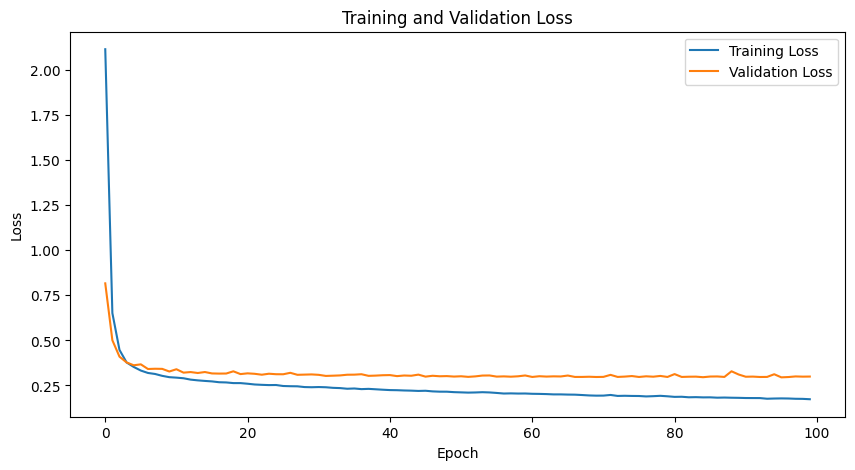

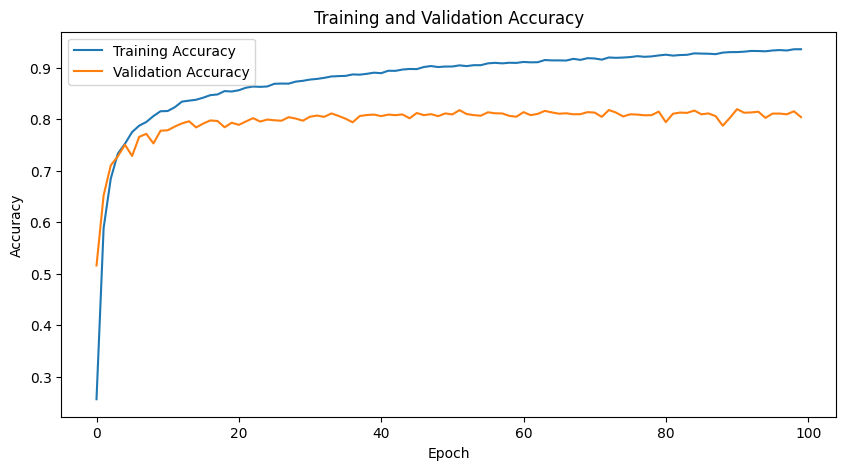

In [208]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 2: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.MSELoss() with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: No specifict learning rate scheduler set, with the constant 0.0002 lr. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 80% val acc around epoch 25, where train acc hits 95% around epoch 100, indicating some overfitting** (Currently)

In [209]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0002)
threshold = 0.1

106


In [210]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 10.5714, Val Loss: 3.1998, Training Accuracy: 7.39%, Validation Accuracy: 14.99%
Epoch 2/100, Loss: 2.4118, Val Loss: 1.4509, Training Accuracy: 31.41%, Validation Accuracy: 44.08%
Epoch 3/100, Loss: 0.9242, Val Loss: 0.6385, Training Accuracy: 50.39%, Validation Accuracy: 55.58%
Epoch 4/100, Loss: 0.4217, Val Loss: 0.3838, Training Accuracy: 61.75%, Validation Accuracy: 62.79%
Epoch 5/100, Loss: 0.2952, Val Loss: 0.3183, Training Accuracy: 67.68%, Validation Accuracy: 68.22%
Epoch 6/100, Loss: 0.2563, Val Loss: 0.2918, Training Accuracy: 70.58%, Validation Accuracy: 71.29%
Epoch 7/100, Loss: 0.2366, Val Loss: 0.2686, Training Accuracy: 72.76%, Validation Accuracy: 71.16%
Epoch 8/100, Loss: 0.2185, Val Loss: 0.2588, Training Accuracy: 74.78%, Validation Accuracy: 73.51%
Epoch 9/100, Loss: 0.2078, Val Loss: 0.2693, Training Accuracy: 75.81%, Validation Accuracy: 70.44%
Epoch 10/100, Loss: 0.1988, Val Loss: 0.2436, Training Accuracy: 76.84%, Validation Accuracy: 72.65%

Epoch 83/100, Loss: 0.0703, Val Loss: 0.2003, Training Accuracy: 93.92%, Validation Accuracy: 78.25%
Epoch 84/100, Loss: 0.0691, Val Loss: 0.1919, Training Accuracy: 94.28%, Validation Accuracy: 79.97%
Epoch 85/100, Loss: 0.0676, Val Loss: 0.2010, Training Accuracy: 94.32%, Validation Accuracy: 79.50%
Epoch 86/100, Loss: 0.0677, Val Loss: 0.2036, Training Accuracy: 94.24%, Validation Accuracy: 78.66%
Epoch 87/100, Loss: 0.0671, Val Loss: 0.1870, Training Accuracy: 94.51%, Validation Accuracy: 80.49%
Epoch 88/100, Loss: 0.0645, Val Loss: 0.1957, Training Accuracy: 94.55%, Validation Accuracy: 78.94%
Epoch 89/100, Loss: 0.0647, Val Loss: 0.1938, Training Accuracy: 94.73%, Validation Accuracy: 80.24%
Epoch 90/100, Loss: 0.0641, Val Loss: 0.2113, Training Accuracy: 94.78%, Validation Accuracy: 78.14%
Epoch 91/100, Loss: 0.0667, Val Loss: 0.1950, Training Accuracy: 94.43%, Validation Accuracy: 79.36%
Epoch 92/100, Loss: 0.0659, Val Loss: 0.1930, Training Accuracy: 94.55%, Validation Accurac

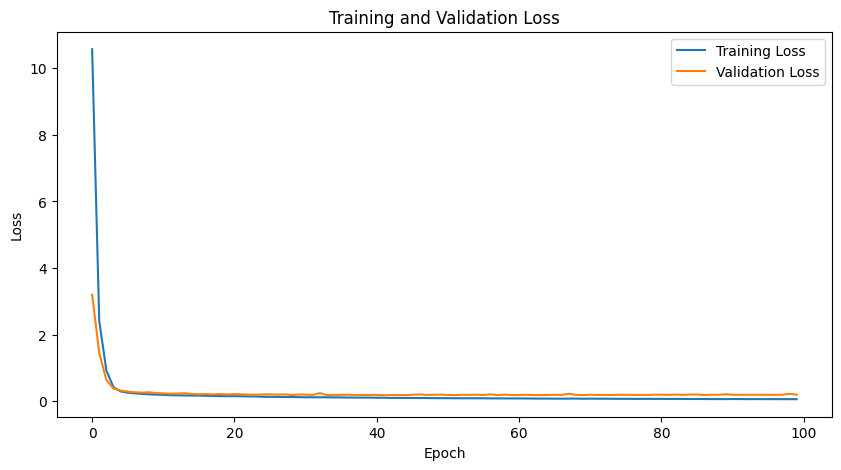

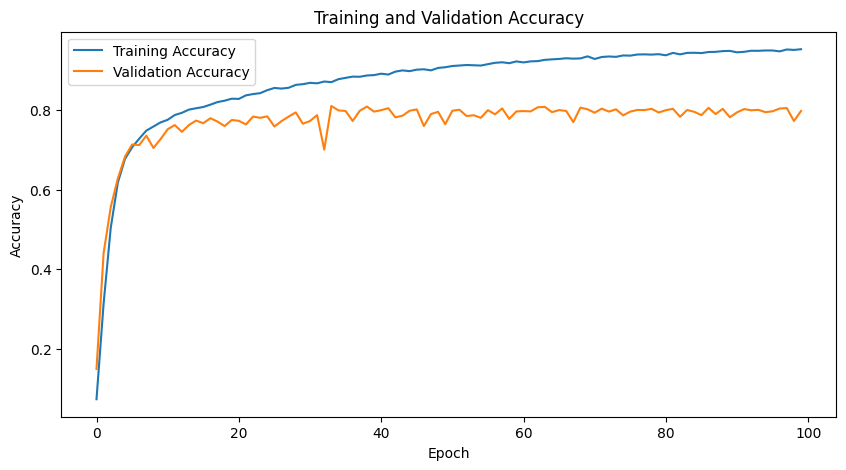

In [211]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 3: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0001.
- **scheduler**: No specifict learning rate scheduler set, with the constant 0.0001 lr. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 80% val acc around epoch 57, where train acc hits 91% around epoch 100** (Currently)

In [214]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
# criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
threshold = 0.1

106


In [213]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.9409, Val Loss: 1.2275, Training Accuracy: 9.97%, Validation Accuracy: 33.25%
Epoch 2/100, Loss: 0.9561, Val Loss: 0.8113, Training Accuracy: 46.10%, Validation Accuracy: 52.01%
Epoch 3/100, Loss: 0.7063, Val Loss: 0.6286, Training Accuracy: 57.10%, Validation Accuracy: 59.55%
Epoch 4/100, Loss: 0.5378, Val Loss: 0.4942, Training Accuracy: 65.20%, Validation Accuracy: 65.25%
Epoch 5/100, Loss: 0.4358, Val Loss: 0.4311, Training Accuracy: 70.50%, Validation Accuracy: 68.91%
Epoch 6/100, Loss: 0.3882, Val Loss: 0.3979, Training Accuracy: 73.10%, Validation Accuracy: 71.49%
Epoch 7/100, Loss: 0.3600, Val Loss: 0.3748, Training Accuracy: 75.44%, Validation Accuracy: 73.26%
Epoch 8/100, Loss: 0.3407, Val Loss: 0.3676, Training Accuracy: 77.32%, Validation Accuracy: 73.68%
Epoch 9/100, Loss: 0.3271, Val Loss: 0.3601, Training Accuracy: 78.31%, Validation Accuracy: 74.40%
Epoch 10/100, Loss: 0.3198, Val Loss: 0.3568, Training Accuracy: 78.95%, Validation Accuracy: 74.87%


Epoch 83/100, Loss: 0.2014, Val Loss: 0.3088, Training Accuracy: 90.55%, Validation Accuracy: 79.61%
Epoch 84/100, Loss: 0.2010, Val Loss: 0.3046, Training Accuracy: 90.56%, Validation Accuracy: 80.33%
Epoch 85/100, Loss: 0.2025, Val Loss: 0.3070, Training Accuracy: 90.65%, Validation Accuracy: 80.58%
Epoch 86/100, Loss: 0.1996, Val Loss: 0.3058, Training Accuracy: 90.63%, Validation Accuracy: 79.75%
Epoch 87/100, Loss: 0.1984, Val Loss: 0.3039, Training Accuracy: 90.69%, Validation Accuracy: 80.16%
Epoch 88/100, Loss: 0.1973, Val Loss: 0.3019, Training Accuracy: 90.78%, Validation Accuracy: 80.30%
Epoch 89/100, Loss: 0.1979, Val Loss: 0.3057, Training Accuracy: 90.79%, Validation Accuracy: 80.63%
Epoch 90/100, Loss: 0.1970, Val Loss: 0.3058, Training Accuracy: 90.75%, Validation Accuracy: 80.22%
Epoch 91/100, Loss: 0.1976, Val Loss: 0.3014, Training Accuracy: 90.78%, Validation Accuracy: 80.52%
Epoch 92/100, Loss: 0.1949, Val Loss: 0.3036, Training Accuracy: 91.11%, Validation Accurac

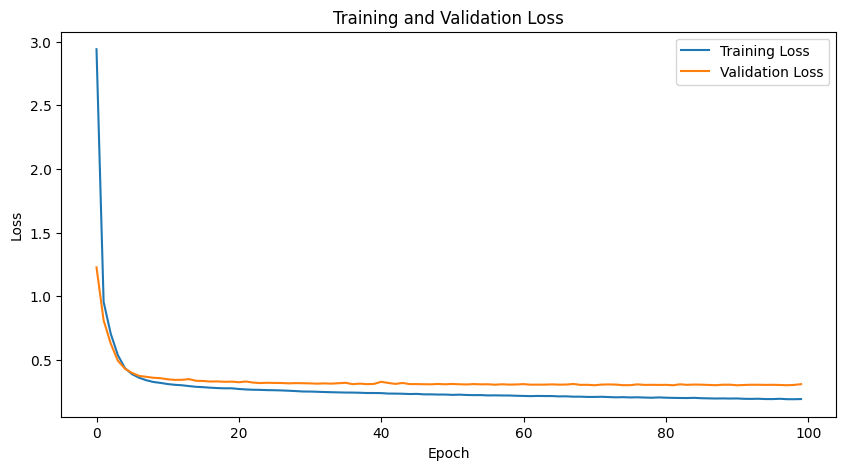

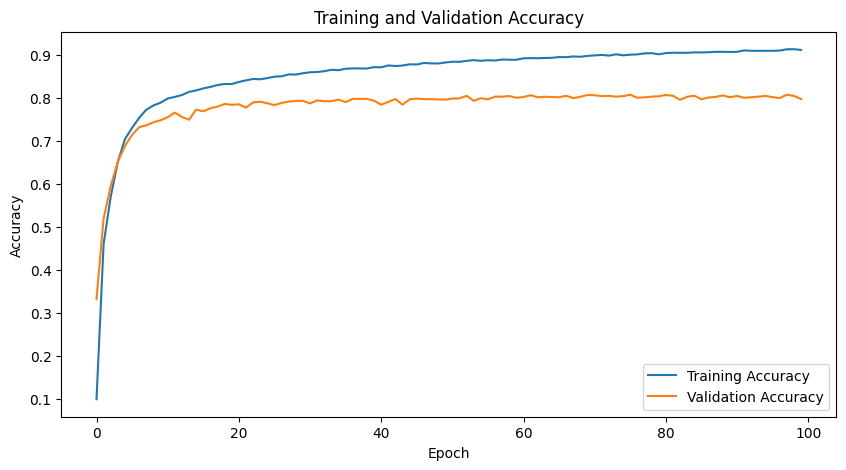

In [215]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 4: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: SGD optimizer used for model parameter optimization with a learning rate of 0.01 and momentum of 0.9.
- **scheduler**: CyclicLR, with max of 0.01 and base_lr of 0.001. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 82% val acc around epoch 90, where train acc hits 93% around epoch 100** (Currently)

In [156]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define cyclic learning rate scheduler
step_size_up = 100  # Number of steps for the learning rate to increase
step_size_down = 200  # Number of steps for the learning rate to decrease
base_lr = 0.001  # Lower boundary for learning rate
max_lr = 0.01  # Upper boundary for learning rate
clr_scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                         step_size_up=step_size_up, step_size_down=step_size_down)

106


In [157]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.3051, Val Loss: 0.5103, Training Accuracy: 23.08%, Validation Accuracy: 61.12%
Epoch 2/100, Loss: 0.4078, Val Loss: 0.3765, Training Accuracy: 68.77%, Validation Accuracy: 72.49%
Epoch 3/100, Loss: 0.3560, Val Loss: 0.3598, Training Accuracy: 74.34%, Validation Accuracy: 73.40%
Epoch 4/100, Loss: 0.3398, Val Loss: 0.3474, Training Accuracy: 76.01%, Validation Accuracy: 75.64%
Epoch 5/100, Loss: 0.3298, Val Loss: 0.3423, Training Accuracy: 77.43%, Validation Accuracy: 76.75%
Epoch 6/100, Loss: 0.3212, Val Loss: 0.3323, Training Accuracy: 78.58%, Validation Accuracy: 77.25%
Epoch 7/100, Loss: 0.3135, Val Loss: 0.3280, Training Accuracy: 79.19%, Validation Accuracy: 78.25%
Epoch 8/100, Loss: 0.3077, Val Loss: 0.3253, Training Accuracy: 79.99%, Validation Accuracy: 78.36%
Epoch 9/100, Loss: 0.3016, Val Loss: 0.3239, Training Accuracy: 80.49%, Validation Accuracy: 79.02%
Epoch 10/100, Loss: 0.2972, Val Loss: 0.3180, Training Accuracy: 80.81%, Validation Accuracy: 79.25%

Epoch 83/100, Loss: 0.1910, Val Loss: 0.2875, Training Accuracy: 91.87%, Validation Accuracy: 81.35%
Epoch 84/100, Loss: 0.1899, Val Loss: 0.2855, Training Accuracy: 91.90%, Validation Accuracy: 82.04%
Epoch 85/100, Loss: 0.1888, Val Loss: 0.2916, Training Accuracy: 91.85%, Validation Accuracy: 81.74%
Epoch 86/100, Loss: 0.1868, Val Loss: 0.2899, Training Accuracy: 92.19%, Validation Accuracy: 81.57%
Epoch 87/100, Loss: 0.1887, Val Loss: 0.2938, Training Accuracy: 91.92%, Validation Accuracy: 81.38%
Epoch 88/100, Loss: 0.1859, Val Loss: 0.2875, Training Accuracy: 92.12%, Validation Accuracy: 82.04%
Epoch 89/100, Loss: 0.1864, Val Loss: 0.2924, Training Accuracy: 92.32%, Validation Accuracy: 81.32%
Epoch 90/100, Loss: 0.1843, Val Loss: 0.2909, Training Accuracy: 92.30%, Validation Accuracy: 81.27%
Epoch 91/100, Loss: 0.1840, Val Loss: 0.2872, Training Accuracy: 92.19%, Validation Accuracy: 82.21%
Epoch 92/100, Loss: 0.1834, Val Loss: 0.2901, Training Accuracy: 92.55%, Validation Accurac

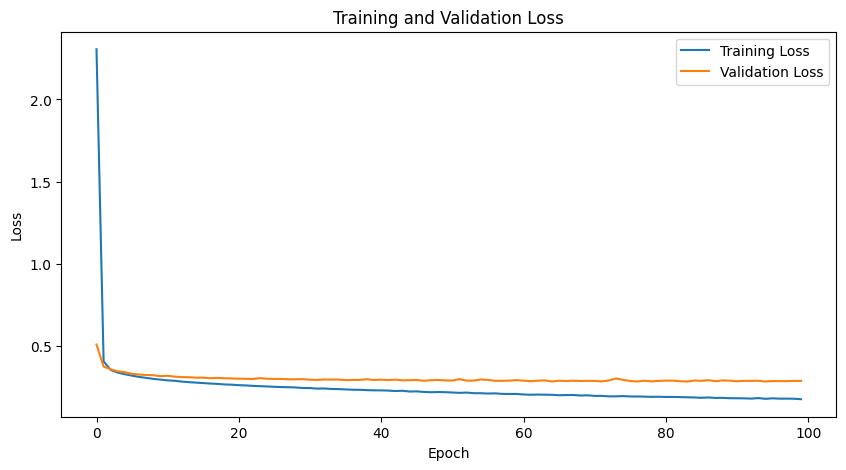

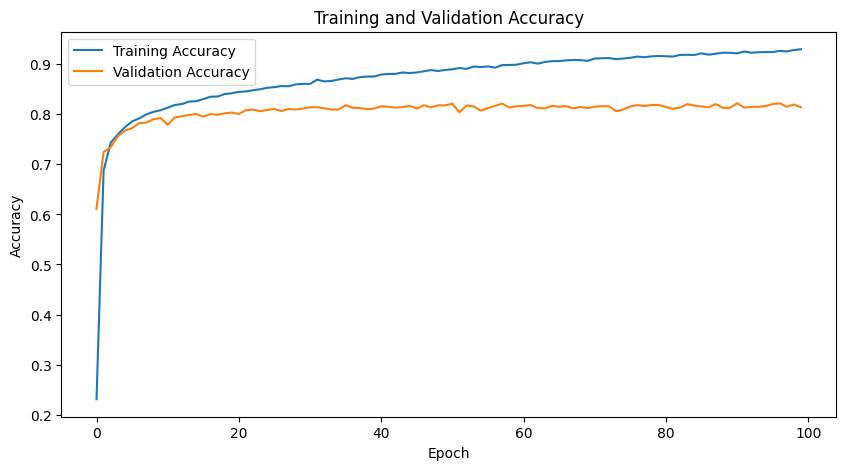

In [158]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 5: （Different Architecture 5-layer with Dropout)
## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit 81% val acc around epoch 55, where train acc hits 93% around epoch 100**  (Currently with Dropout)
### We can see a slightly worse val acc due to the regularization technique here. 



In [182]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [183]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.1449, Val Loss: 0.8524, Training Accuracy: 26.19%, Validation Accuracy: 51.84%
Epoch 2/100, Loss: 0.6701, Val Loss: 0.5230, Training Accuracy: 59.44%, Validation Accuracy: 64.89%
Epoch 3/100, Loss: 0.4505, Val Loss: 0.4029, Training Accuracy: 69.57%, Validation Accuracy: 72.37%
Epoch 4/100, Loss: 0.3739, Val Loss: 0.3719, Training Accuracy: 74.13%, Validation Accuracy: 74.20%
Epoch 5/100, Loss: 0.3439, Val Loss: 0.3567, Training Accuracy: 76.90%, Validation Accuracy: 75.06%
Epoch 6/100, Loss: 0.3310, Val Loss: 0.3518, Training Accuracy: 77.87%, Validation Accuracy: 75.51%
Epoch 7/100, Loss: 0.3181, Val Loss: 0.3492, Training Accuracy: 79.03%, Validation Accuracy: 75.78%
Epoch 8/100, Loss: 0.3098, Val Loss: 0.3406, Training Accuracy: 80.22%, Validation Accuracy: 76.59%
Epoch 9/100, Loss: 0.3049, Val Loss: 0.3372, Training Accuracy: 80.59%, Validation Accuracy: 77.03%
Epoch 10/100, Loss: 0.2965, Val Loss: 0.3333, Training Accuracy: 81.69%, Validation Accuracy: 77.20%

Epoch 83/100, Loss: 0.1909, Val Loss: 0.2984, Training Accuracy: 92.30%, Validation Accuracy: 80.85%
Epoch 84/100, Loss: 0.1911, Val Loss: 0.3002, Training Accuracy: 92.40%, Validation Accuracy: 80.80%
Epoch 85/100, Loss: 0.1874, Val Loss: 0.2984, Training Accuracy: 92.33%, Validation Accuracy: 81.21%
Epoch 86/100, Loss: 0.1883, Val Loss: 0.2963, Training Accuracy: 92.20%, Validation Accuracy: 81.46%
Epoch 87/100, Loss: 0.1857, Val Loss: 0.2964, Training Accuracy: 92.43%, Validation Accuracy: 81.41%
Epoch 88/100, Loss: 0.1854, Val Loss: 0.2952, Training Accuracy: 92.56%, Validation Accuracy: 81.30%
Epoch 89/100, Loss: 0.1841, Val Loss: 0.2988, Training Accuracy: 92.54%, Validation Accuracy: 80.74%
Epoch 90/100, Loss: 0.1860, Val Loss: 0.2959, Training Accuracy: 92.53%, Validation Accuracy: 81.35%
Epoch 91/100, Loss: 0.1826, Val Loss: 0.2944, Training Accuracy: 92.88%, Validation Accuracy: 81.49%
Epoch 92/100, Loss: 0.1824, Val Loss: 0.3007, Training Accuracy: 93.01%, Validation Accurac

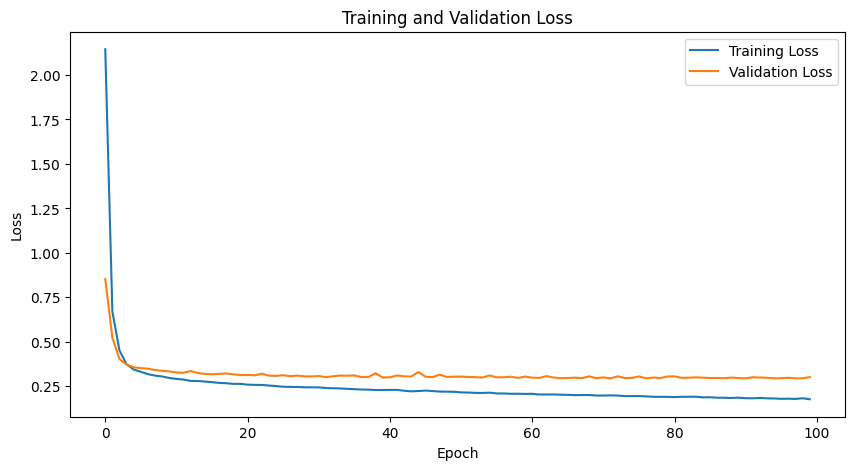

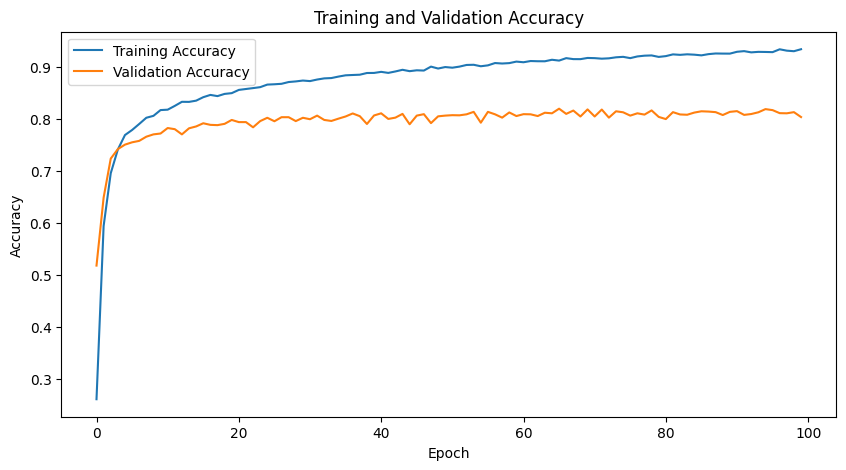

In [184]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 6: （Different Architecture 5-layer with BatchNormalization)
## Hyperparameters (from the winner of the basci 5-layer architecture): 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit 82% val acc around epoch 60, where train acc hits 91% around epoch 95**  (Currently with BatchNormalization)
### We can see a slightly worse val and train acc with Batch Normalization. 



In [185]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictorBN(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [186]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 3.7271, Val Loss: 1.4826, Training Accuracy: 1.59%, Validation Accuracy: 11.61%
Epoch 2/100, Loss: 0.5910, Val Loss: 0.3776, Training Accuracy: 54.82%, Validation Accuracy: 73.01%
Epoch 3/100, Loss: 0.3935, Val Loss: 0.3506, Training Accuracy: 69.93%, Validation Accuracy: 76.20%
Epoch 4/100, Loss: 0.3563, Val Loss: 0.3441, Training Accuracy: 74.31%, Validation Accuracy: 76.17%
Epoch 5/100, Loss: 0.3416, Val Loss: 0.3257, Training Accuracy: 76.14%, Validation Accuracy: 79.05%
Epoch 6/100, Loss: 0.3336, Val Loss: 0.3309, Training Accuracy: 77.23%, Validation Accuracy: 78.17%
Epoch 7/100, Loss: 0.3270, Val Loss: 0.3249, Training Accuracy: 77.58%, Validation Accuracy: 78.89%
Epoch 8/100, Loss: 0.3160, Val Loss: 0.3287, Training Accuracy: 79.83%, Validation Accuracy: 79.11%
Epoch 9/100, Loss: 0.3133, Val Loss: 0.3147, Training Accuracy: 79.80%, Validation Accuracy: 79.25%
Epoch 10/100, Loss: 0.3091, Val Loss: 0.3203, Training Accuracy: 80.04%, Validation Accuracy: 79.19%


Epoch 83/100, Loss: 0.2205, Val Loss: 0.2868, Training Accuracy: 90.87%, Validation Accuracy: 82.77%
Epoch 84/100, Loss: 0.2192, Val Loss: 0.2921, Training Accuracy: 90.57%, Validation Accuracy: 82.32%
Epoch 85/100, Loss: 0.2189, Val Loss: 0.2906, Training Accuracy: 90.60%, Validation Accuracy: 82.43%
Epoch 86/100, Loss: 0.2188, Val Loss: 0.2896, Training Accuracy: 90.46%, Validation Accuracy: 82.63%
Epoch 87/100, Loss: 0.2199, Val Loss: 0.2886, Training Accuracy: 90.62%, Validation Accuracy: 82.46%
Epoch 88/100, Loss: 0.2190, Val Loss: 0.2884, Training Accuracy: 90.73%, Validation Accuracy: 82.32%
Epoch 89/100, Loss: 0.2182, Val Loss: 0.2862, Training Accuracy: 90.58%, Validation Accuracy: 82.60%
Epoch 90/100, Loss: 0.2173, Val Loss: 0.2901, Training Accuracy: 90.77%, Validation Accuracy: 82.38%
Epoch 91/100, Loss: 0.2157, Val Loss: 0.2903, Training Accuracy: 91.24%, Validation Accuracy: 82.21%
Epoch 92/100, Loss: 0.2157, Val Loss: 0.2885, Training Accuracy: 90.92%, Validation Accurac

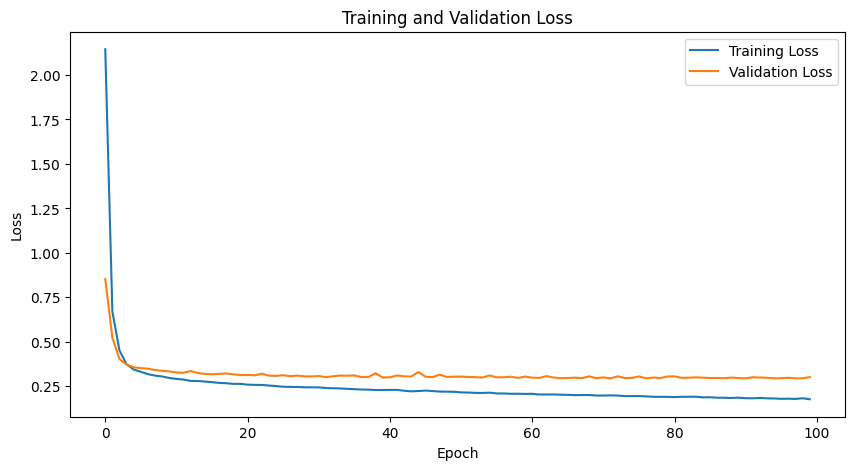

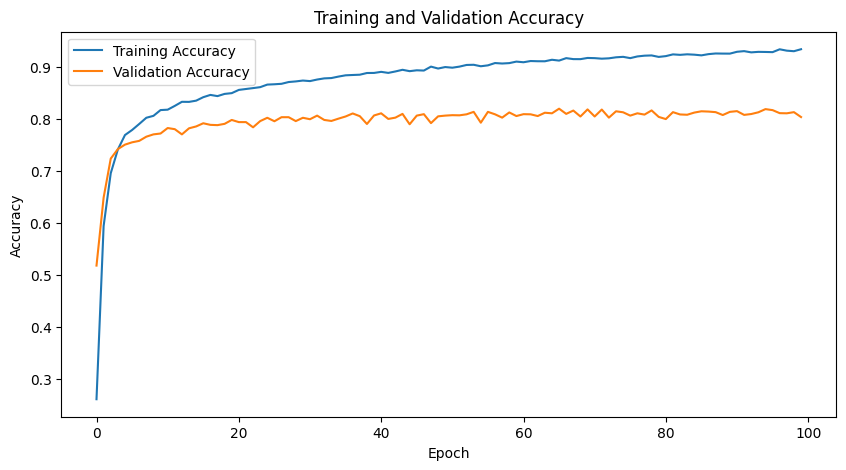

In [184]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 7: （Different Architecture 9-layer)
## Hyperparameters (from the winner of the basci 5-layer architecture): 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit almost 82% val acc around epoch 98, where train acc hits alsmot 98% around epoch 100**  (Currently with 9 layers)
### Although with more layers, we can see a much better train accuracy, but we do not see a better val accuracy. This may indicate that overfitting has occurred with this more complex architecture. We also see some unusual val acc fluctuations around epoch 16. 


In [192]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor9Layer(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [193]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 1.4369, Val Loss: 0.5438, Training Accuracy: 39.15%, Validation Accuracy: 60.52%
Epoch 2/100, Loss: 0.4428, Val Loss: 0.3831, Training Accuracy: 67.87%, Validation Accuracy: 73.95%
Epoch 3/100, Loss: 0.3632, Val Loss: 0.3599, Training Accuracy: 74.54%, Validation Accuracy: 74.59%
Epoch 4/100, Loss: 0.3470, Val Loss: 0.3766, Training Accuracy: 75.81%, Validation Accuracy: 73.87%
Epoch 5/100, Loss: 0.3252, Val Loss: 0.3382, Training Accuracy: 78.27%, Validation Accuracy: 77.83%
Epoch 6/100, Loss: 0.3203, Val Loss: 0.3287, Training Accuracy: 78.95%, Validation Accuracy: 78.44%
Epoch 7/100, Loss: 0.3060, Val Loss: 0.3399, Training Accuracy: 80.90%, Validation Accuracy: 76.53%
Epoch 8/100, Loss: 0.3011, Val Loss: 0.3291, Training Accuracy: 81.22%, Validation Accuracy: 77.94%
Epoch 9/100, Loss: 0.2947, Val Loss: 0.3239, Training Accuracy: 81.79%, Validation Accuracy: 78.91%
Epoch 10/100, Loss: 0.2885, Val Loss: 0.3233, Training Accuracy: 82.69%, Validation Accuracy: 78.83%

Epoch 83/100, Loss: 0.1511, Val Loss: 0.2917, Training Accuracy: 96.00%, Validation Accuracy: 81.85%
Epoch 84/100, Loss: 0.1510, Val Loss: 0.2930, Training Accuracy: 96.00%, Validation Accuracy: 81.35%
Epoch 85/100, Loss: 0.1505, Val Loss: 0.2901, Training Accuracy: 96.11%, Validation Accuracy: 81.49%
Epoch 86/100, Loss: 0.1501, Val Loss: 0.2950, Training Accuracy: 96.20%, Validation Accuracy: 81.52%
Epoch 87/100, Loss: 0.1514, Val Loss: 0.2958, Training Accuracy: 96.15%, Validation Accuracy: 81.05%
Epoch 88/100, Loss: 0.1475, Val Loss: 0.2945, Training Accuracy: 96.24%, Validation Accuracy: 81.32%
Epoch 89/100, Loss: 0.1460, Val Loss: 0.2941, Training Accuracy: 96.39%, Validation Accuracy: 81.55%
Epoch 90/100, Loss: 0.1448, Val Loss: 0.2910, Training Accuracy: 96.45%, Validation Accuracy: 81.57%
Epoch 91/100, Loss: 0.1466, Val Loss: 0.3079, Training Accuracy: 96.20%, Validation Accuracy: 79.77%
Epoch 92/100, Loss: 0.1445, Val Loss: 0.2906, Training Accuracy: 96.46%, Validation Accurac

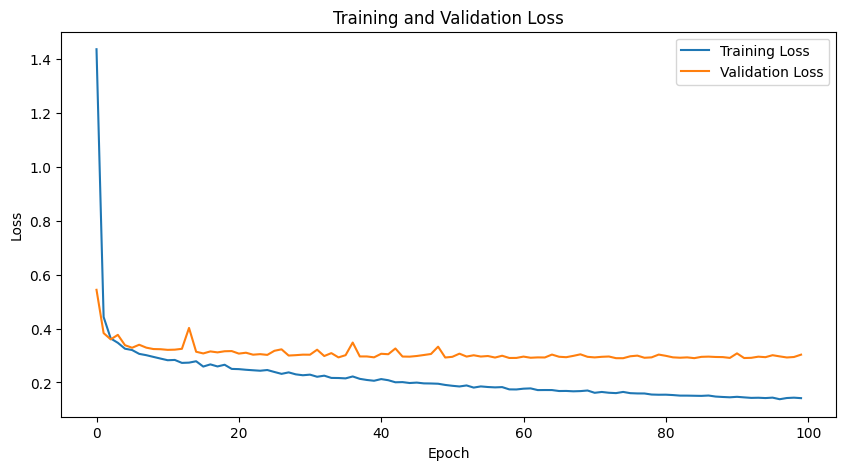

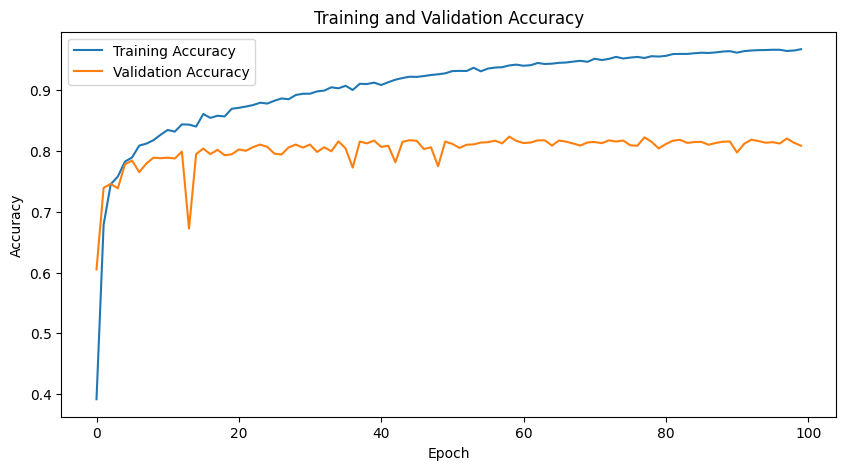

In [194]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
